In [1]:
from time import time
start = time()

In [2]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.figure_factory as ff
import plotly.express as px
from sklearn.neighbors import KernelDensity

In [3]:
# Bright seaborn plots
sns.set_theme(palette="bright")

# load R extention to jupyter-lab cells
# (it's useful to combine python and R coding, but R is limited here, use R-studio instead
# if you gonna use only R)
%load_ext rpy2.ipython

In [80]:
%%R

# R packages used

library("lsr")
library("ggplot2")  
library("car")
library("PMCMRplus")

### Confidence Intervals (CI) and Bootstrapping

A confidence interval is a range of values representing how confidence we are about some parameter (e.g mean, mode, median, etc) of the population based only in a sample.

Usually when working with data we only have a sample of the population rather than the whole population. However, we are able to estimate a range of values of possible values of a parameter (generally the mean o $\mu$) of the population if we have a significant sample data. Thus, the central limit theorem states that the distribution of sample means approximates a normal distribution and, as you already may know, we are able to retrieve aprox. 95% of our data covering two (to be more accurate is 1.96) standard deviation ($\sigma$) to the right and left from the mean.

Getting the means of random samples of the population and retrieving the 95% of that distribution (normal distribution because the central limit theorem) give us the confidence interval of the true mean population with a confidence of 95% based on the sample, the larger the data sample size, the better the confidence interval obtained. We can also obtain other confidence intervals, for example, a confidence interval of 99% taking aprox 3$\sigma$ from the rigth and left of the distribution of the means.

If we have multiples samples, the confidence interval can be computed getting the means of the samples and then retrieving the limit inferior of the real values of the parameter as the percentile number 0.025 and the superior with aprox 0.975, the range of values between those percentiles encompasses the 95% of all the data but, if we have only one sample, we can calculate the standard error (SE), which is the standard deviation of the means of multiples samples of the population, and multiply it for 1.96 ($\sigma$)

$$
limit\ inferior = \mu - SE * 1.96
$$

$$
limit\ superior = \mu + SE * 1.96
$$

The general representation to calculate the CI is also shown as:

$$
CI = \mu\ \pm \ z * \frac{s}{\sqrt{n}}\ \ \ \ \ \ \ \ z=confidence\ level\ value;\ s=standard\ deviation\ of\ the\ sample;\ n=sample\ size
$$

Calculating the CI as shown above assumes your data is normal distributed, which is not always the case. In this situation, we also take advantage of a powerful method called bootstrapping. 

Bootstrapping basically does a resampling of your sample calculating virtually any parameter of interest to us wich tries to describe the population parameter. This resampling is computed taking a sample of your sample of the same size but allowing repetition, for each sampled sample the parameter is calculated and, from here, several methods have been determined to calculate the CI: empirical bootstapping (here also known as basic or reverse), normal, percentile, etc.

Thus, for example, normal bootstrapping uses the definition of CI for normal data (see above) because the parameters obtained from the sampled samples follow a normal distribution, substituting the $mu$ for the $mu^*$ or mean of your sampled samples or the parameter of your interest and the $SE$ for the $SE^*$ again, of your sampled samples.

On the other hand, empirical defines the CI for the mean as:

$$
CI = (2\overline{x} - x^*_{1 - \frac{\alpha}{2}},\ 2\overline{x} - x^*_{\frac{\alpha}{2}})
$$

$$
where\ \overline{x}\ is\ the\ mean\ of\ the\ original\ data(the\ sample)
$$

$$
x^*\ is\ the\ mean\ of\ the\ sampled\ samples\ found\ in\ the\ percentiles\\
$$

$$
1\ -\ \frac{\alpha}{2}\ and\ \frac{\alpha}{2}\ (these\ are\ the\ percentiles)
$$

In [5]:
# Lets create random normal data to ilustrate the interval confidence
norm_pop = np.random.normal(10, 1, 100000)

print(f"True mean population: {norm_pop.mean()}")

True mean population: 10.001183273721775


In [6]:
# Now lets get the confidence intervals with a confidence of 95% based on only a random sample

def ShowCI95(population:"array-like", sample_size:int):
    
    '''
    Show on screen the 95% confidence interval of the mean
    
    This functions print on screen the range of values of the 95% confidence intervals based on a 
    sample of the population provided
    
    Parameters
    ----------
    
    population: array-like
        array-like representing the population where a sample of size sample_size will be taken
        
    sample_size: integer, int
        size of the sample
            
    
    Examples
    ----------
    
    >>>import numpy as np
    >>>import pandas as pd
    >>>data = np.random.normal(0,1,10000)
    >>>ShowCI95(data, 1000)
    Sample size: 1000
    Sample mean: -0.006450809541726166
    True mean population is between -0.06841125689868024 and 0.055509637815227914 with a confidence of 95%
    The sample mean has an aprox error of -0.006 +/- 0.062
    
    
    '''

    norm_sam = np.random.choice(population, sample_size)
    
    # sem() is a pandas function to get the SE
    error = pd.Series(norm_sam).sem() * 1.96
    mu = norm_sam.mean()
    
    l_inf = mu - error
    l_sup = mu + error

    print(f"Sample size: {norm_sam.shape[0]}")
    print(f"Sample mean: {norm_sam.mean()}")
    print(f"True mean population is between {l_inf} and {l_sup} with a confidence of 95%")
    print(f"The sample mean has an aprox error of {round(mu, 3)} +/- {round(error, 3)}")
    
ShowCI95(norm_pop, 5000)

Sample size: 5000
Sample mean: 9.985306151834646
True mean population is between 9.957359457619205 and 10.013252846050086 with a confidence of 95%
The sample mean has an aprox error of 9.985 +/- 0.028


In [7]:
# Lets now to try to find out the confidence interval using random sampling of the population
# Every sample will be of 5000 data points and 100 samples will be done

print(f"True population mean {norm_pop.mean()}")

means = []

for experiment in range(100):
    mu = np.random.choice(norm_pop, 5000).mean()
    means.append(mu)

means = pd.Series(means)
    
print(f"The mean of the sample means is {means.mean()}")

# If we take the percentiles covering the 95 percent of the means obtained, we are getting the confidence
# intervals with a confidence of 95%
P_025 = means.quantile(0.025)
P_975 = means.quantile(0.975)

print(f"The 95% confidence interval range from the value {P_025} to {P_975}")

True population mean 10.001183273721775
The mean of the sample means is 10.000106405400066
The 95% confidence interval range from the value 9.976537230519062 to 10.023035257658233


In [8]:
# The error increases as the sample data size decreases

for size in [10000,5000,2500,1000,500,250,125]:
    ShowCI95(norm_pop, size)
    print("")


Sample size: 10000
Sample mean: 10.014613043508827
True mean population is between 9.995155319263068 and 10.034070767754587 with a confidence of 95%
The sample mean has an aprox error of 10.015 +/- 0.019

Sample size: 5000
Sample mean: 10.011569852200077
True mean population is between 9.983507471364861 and 10.039632233035293 with a confidence of 95%
The sample mean has an aprox error of 10.012 +/- 0.028

Sample size: 2500
Sample mean: 10.023909195786782
True mean population is between 9.984968785557635 and 10.062849606015929 with a confidence of 95%
The sample mean has an aprox error of 10.024 +/- 0.039

Sample size: 1000
Sample mean: 9.999802732314281
True mean population is between 9.937465212468334 and 10.062140252160228 with a confidence of 95%
The sample mean has an aprox error of 10.0 +/- 0.062

Sample size: 500
Sample mean: 9.976156206067929
True mean population is between 9.882575085776127 and 10.06973732635973 with a confidence of 95%
The sample mean has an aprox error of 9.9

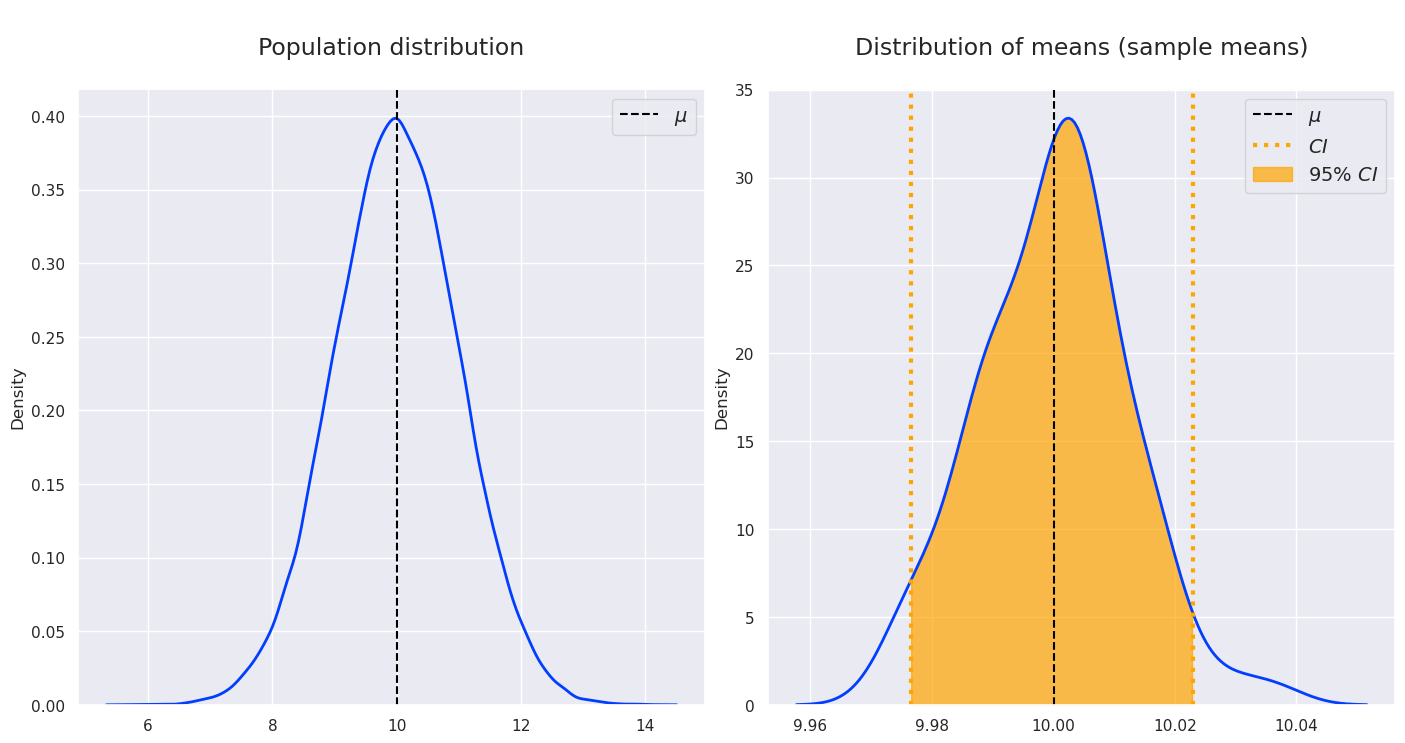

In [9]:
# The mean of the sample means is pretty much the same as the population mean but, in reality, we wouldn't know that
# Now lets see the population distribution and the distributions of the sample means

# Population plot
fig, (ax_1, ax_2) = plt.subplots(1,2, figsize=(17, 8))

sns.kdeplot(norm_pop, linewidth=2, ax=ax_1)
ax_1.axvline(norm_pop.mean(), c="black", linestyle="--", label="$\mu$")
ax_1.set_title("\nPopulation distribution\n", fontdict={"size":17})
ax_1.legend(fontsize=14)

# Means plot
sns.kdeplot(means, linewidth=2, ax=ax_2)

# Mean and 95% of the data
ax_2.axvline(means.mean(), c="black", linestyle="--", label="$\mu$")
ax_2.axvline(P_025, c="orange", linestyle="dotted", linewidth=3, label="$CI$")
ax_2.axvline(P_975, c="orange", linestyle="dotted", linewidth=3)

X_fill, Y_fill = ax_2.get_lines()[0].get_data()
mask = (X_fill >= P_025) & (X_fill <= P_975)
ax_2.fill_between(X_fill[mask], Y_fill[mask], color="orange", alpha=0.7, label="$95\%\ CI$")

ax_2.set_title("\nDistribution of means (sample means)\n", fontdict={"size":17})
ax_2.legend(fontsize=14)

plt.subplots_adjust(wspace=0.1)
plt.show()

In [10]:
# Now let's bootstrapping for the basic and percentile method to ilustrate its power in non-normal data
# We are going to create a Bootstrapping class just because, take your time to decode the python class below

class Bootstrapping:
    
    '''
    Bootstrapping resampling the sample
    
    This class does two types of bootsrapping based on the mean of the sample and return
    the low and upper confident intervals of the mean. The methods avaliable are basic
    bootstrapping, also known as Reverse Percentile Interval or Empirical bootstrapping.
    This function also computes the percentile boostrapping
    
    Parameters
    ----------
    
    data: array-like
        sample to be resampled
    
    tests: integer, int. Default 10,000
        integer indicating how many times the sample will be resample. Default 10,000
        
        
    Return
    ------
        tuple: tuple with the inferior limit and upper limit of the confidence interval
    
    
    Examples
    --------
    
    >>>from numpy.random import normal
    >>>sample = normal(0, 1, 1000)
    >>>boot = Bootstrapping(sample, tests=1000)
    >>>boot.basic()
    (-0.044194517957389545, 0.07898892888826403)
    
    '''
    
    def __init__(self, data:"array-like", tests:int=10000):
        
        self.data  = np.array(data).reshape(-1,)
        self.tests = tests
        
        self.mean = self.data.mean()
        self.std  = self.data.std()
    
    def __percentileLimits(self, means, lower, upper):
            return (np.percentile(means, lower), np.percentile(means, upper))
        
    def __bootstrap(self, sample):
            # Resampling the sample and computing the mean of the sample of the sample
            # This is basically bootstrapping
            means = []
            for _ in range(self.tests):
                mu = np.random.choice(self.data, self.data.shape[0], replace=True).mean()
                means.append(mu)
            
            return np.array(means).reshape(-1,)
        
    def basic(self, confidence=95):
        
        '''
        Get the confidence intervals based on the definition:

        CI = (low = 2X - x_{1 - a/2}, high = 2X - x_{a/2})
            where "X" is the sample/original mean, "x" is the mean found in the {1 - a/2} or 
            {a/2} percentile of the sample resampled and "a" means alpha, the value of the tail
            of the normal distribution
        
        '''
        
        means = self.__bootstrap(self.data)
        
        alpha = (100 - confidence) / 2
        lower_limit, upper_limit = self.__percentileLimits(means, alpha, 100 - alpha)
        
        return (2 * self.mean - upper_limit, 2 * self.mean - lower_limit)
    
    def percentile(self, confidence=95):
        
        '''
        Get the confidence intervals based on the definition:

        CI = (low = x_{a/2}, high = x_{1 - a/2})
            where x" is the mean found in the {1 - a/2} or {a/2} percentile of the
            sample resampled and "a" means alpha, the value of the tail of the normal
            distribution
        
        '''
        
        means = self.__bootstrap(self.data)
        alpha = (100 - confidence) / 2
        return self.__percentileLimits(means, alpha, 100 - alpha)

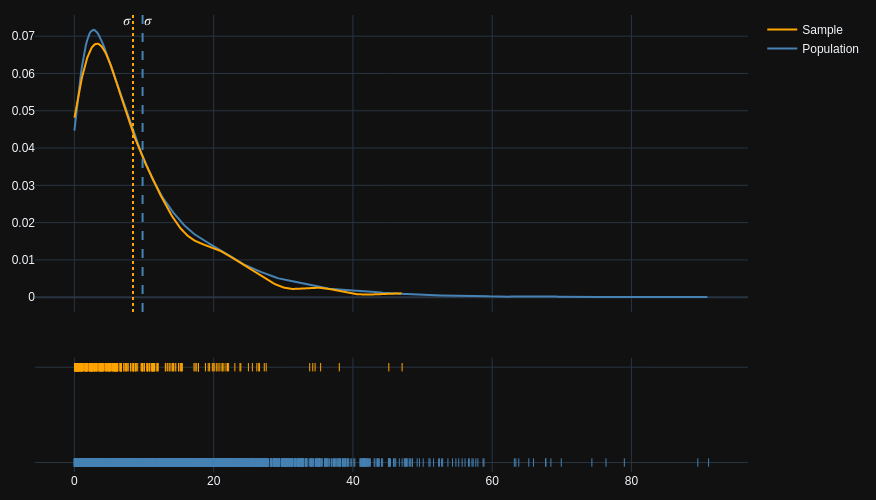

In [11]:
# Here it's our non-normal data population and sample (no samples of the sample)

exp_pop = np.random.exponential(10, 5000)
exp_sam = np.random.choice(exp_pop ,250)

# Plotting using plotly to visualize better the means (interactive but no preview on github)
fig = ff.create_distplot([exp_pop, exp_sam], ["Population","Sample"], show_hist=False,
                         curve_type='kde', colors=["steelblue","orange"])

fig.add_vline(exp_pop.mean(), annotation={"text":"$\sigma$"},
              annotation_position="top right", line_color="steelblue",
              line_dash="dash")

fig.add_vline(exp_sam.mean(), annotation={"text":"$\sigma$"}, 
              annotation_position="top left", line_color="orange",
              line_dash="dot")

fig.update_layout(
    margin=dict(l=20, r=20, t=15, b=15),
    width=860,
    height=500,
    template="plotly_dark"
)

fig.show()

In [12]:
# Now let's get the CI using our class and resampling 10000 times (default value of the class)
boots = Bootstrapping(exp_sam)

# Basic and percentile with confidence of 95%
Confidence = 95
low_b, high_b = boots.basic(confidence=Confidence)
low_p, high_p = boots.percentile(confidence=Confidence)

print(f"\nTrue population mean:{exp_pop.mean()}")
print("\nCI USING BASIC AND PERCENTILE BOOTSTRAPPING")
print("\nBasic bootstrapping:")
print(f"\tThe {Confidence}% confidence interval range from the value {low_b} to {high_b}")
print("\nPercentile bootstrapping:")
print(f"\tThe {Confidence}% confidence interval range from the value {low_p} to {high_p}")


True population mean:9.793813455880532

CI USING BASIC AND PERCENTILE BOOTSTRAPPING

Basic bootstrapping:
	The 95% confidence interval range from the value 7.343004174807183 to 9.423989863301749

Percentile bootstrapping:
	The 95% confidence interval range from the value 7.385179128224044 to 9.51909479982267


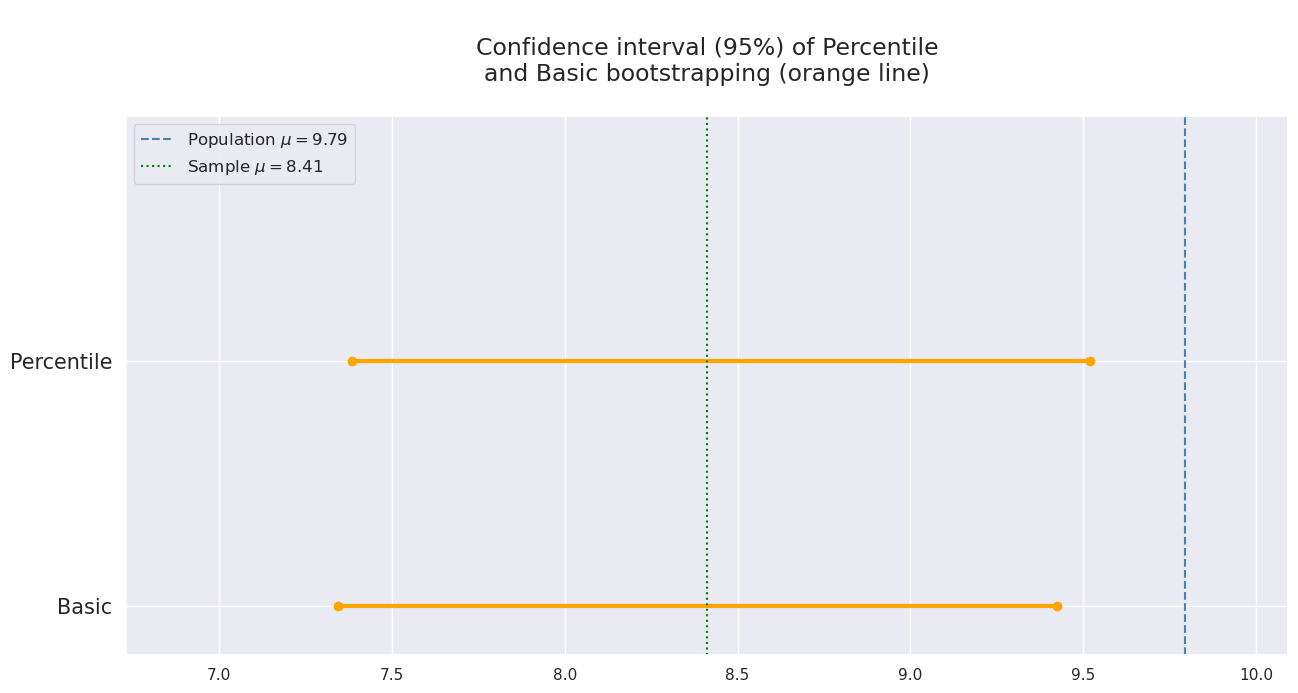

In [13]:
# Let's plot the results
data_dict = {}
data_dict['category'] = ['Basic','Percentile']
data_dict['lower'] = [low_b, low_p]
data_dict['upper'] = [high_b, high_p]
dataset = pd.DataFrame(data_dict)

plt.figure(figsize=(15,7))
y_axis = np.arange(0, dataset.shape[0] / 2, 0.5)
for lower, upper,y in zip(dataset['lower'], dataset['upper'], y_axis):
    plt.plot((lower,upper),(y,y),'o-', color="orange", linewidth=3)

plt.axvline(exp_pop.mean(), linestyle="--", c="steelblue", label=f"Population $\mu={round(exp_pop.mean(),2)}$")
plt.axvline(exp_sam.mean(), linestyle="dotted", c="green", label=f"Sample $\mu={round(exp_sam.mean(),2)}$")

plt.ylim(-0.1, 1)
plt.xlim( exp_sam.mean() - (exp_sam.mean() / 5), exp_sam.mean() + (exp_sam.mean() / 5) )
plt.yticks(y_axis, list(dataset['category']), fontsize=15)
plt.legend(fontsize=12)
plt.title("\nConfidence interval (95%) of Percentile\nand Basic bootstrapping (orange line)\n", fontdict={"size":17})
plt.show()

In [14]:
# We don't need to code our functions/classes to calcute the CI using bootstrap. scipy has already an implementation
# for basic, percentile and another one called bca (which is a litle bit more complicated to code)

boots_types = {"percentile":np.NaN, "basic":np.NaN, "bca":np.NaN}

for key in boots_types:
    b = stats.bootstrap((exp_sam,), np.mean, confidence_level=0.95, method=key)
    boots_types[key] = b.confidence_interval

boots_types

{'percentile': ConfidenceInterval(low=7.369175097490141, high=9.499462267728816),
 'basic': ConfidenceInterval(low=7.344439058219539, high=9.437895816528883),
 'bca': ConfidenceInterval(low=7.424404432040284, high=9.515802785336112)}

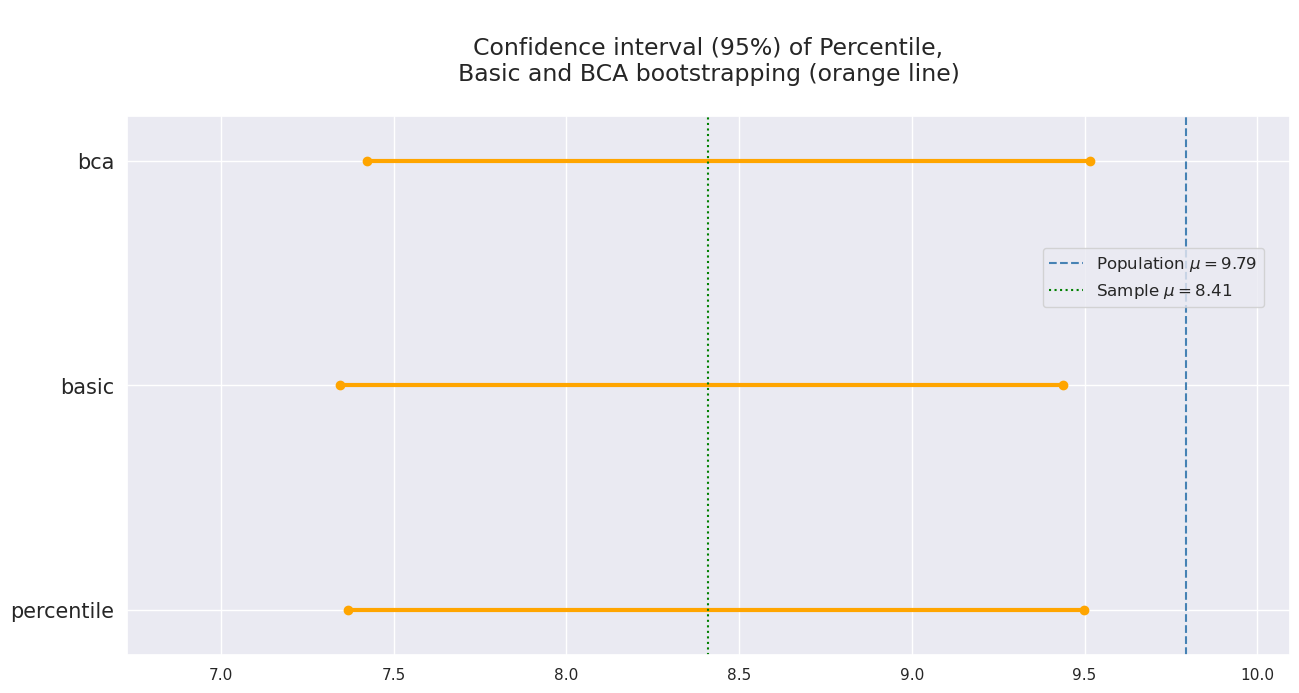

In [15]:
# Let's plot the results of scipy

b = boots_types
data_dict = {}
data_dict['category'] = ['percentile', 'basic', 'bca']
data_dict['lower'] = [b["percentile"].low, b["basic"].low, b["bca"].low]
data_dict['upper'] = [b["percentile"].high, b["basic"].high, b["bca"].high]
dataset = pd.DataFrame(data_dict)

plt.figure(figsize=(15,7))
y_axis = np.arange(0, dataset.shape[0] / 2, 0.5)
for lower, upper,y in zip(dataset['lower'], dataset['upper'], y_axis):
    plt.plot((lower,upper),(y,y),'o-', color="orange", linewidth=3)

plt.axvline(exp_pop.mean(), linestyle="--", c="steelblue", label=f"Population $\mu={round(exp_pop.mean(),2)}$")
plt.axvline(exp_sam.mean(), linestyle="dotted", c="green", label=f"Sample $\mu={round(exp_sam.mean(),2)}$")

plt.ylim(-0.1, 1.1)
plt.xlim( exp_sam.mean() - (exp_sam.mean() / 5), exp_sam.mean() + (exp_sam.mean() / 5) )
plt.yticks(y_axis, list(dataset['category']), fontsize=15)
plt.legend(loc="center right", fontsize=12, bbox_to_anchor=(0.985, 0.7))
plt.title("\nConfidence interval (95%) of Percentile,\nBasic and BCA bootstrapping (orange line)\n", fontdict={"size":17})
plt.show()

### P-value

A p-value is the probability of obtaining equal or rarer observations from your data point or observation. This translates as the area under the curve of the tails of your data distribution (see above plot).

This p-value ($p$) is used to reject or not a null hypothesis. Any hypothesis that is not null is simply denoted as an alternative. To reject or not the null, an alpha ($\alpha$) value is chosen as a cutoff to denote at what probability an observation can be considered extraordinary, this $\alpha$ value is usually chosen as 0.05, although in reality it tends to be an arbitrary value. Thus, depending on the "error" one is willing to accept, $\alpha$ can vary, for example, being stricter with values of 0.001 (accepting one "error" per 1000 observations) or 0.2 (one "error" per 5 cases). Thus, with a value of $p < \alpha$ the null hypothesis can be rejected and we would go for the alternative hypothesis, otherwise, with $p >  \alpha$, we would not have enough evidence to reject the null hypothesis.

On the other hand, how the heck are those hypotheses determined? Well, several "definitions" of what a null hypothesis is can be found such as "What is accepted by default", "Whatever is known or already defined", "What we do not want to test, or more formal "hypothesis that proposes that no statistical significance exists in a set of given observations", while the alternative is "What we are interested in knowing", but the reality is that they are somewhat ambiguous and personal criteria can certainly bias the determination of the hypothesis and end up choosing the wrong one (as may do, incluiding me). In fact, the choice of which hypothesis should be configured as the alternative or null is a much more complex process and will not be discussed in detail here. However, a more descriptive article about this can be found [somewhere else](https://towardsdatascience.com/hypothesis-testing-decoded-for-movers-and-shakers-bfc2bc34da41). The reality is that many statistical tests have already defined which is their null hypothesis and, therefore, which is the alternative.

In [16]:
# Let's get normal data and point out those "extraordinary" observations
normal = np.random.normal(10, 5, 5000)

# tails based on alpha = 0.05 o just 0.025 for each tail (right and left)
alpha_tail = 0.05 / 2
left_tail = np.quantile(normal, alpha_tail)
right_tail= np.quantile(normal, 1 - alpha_tail)

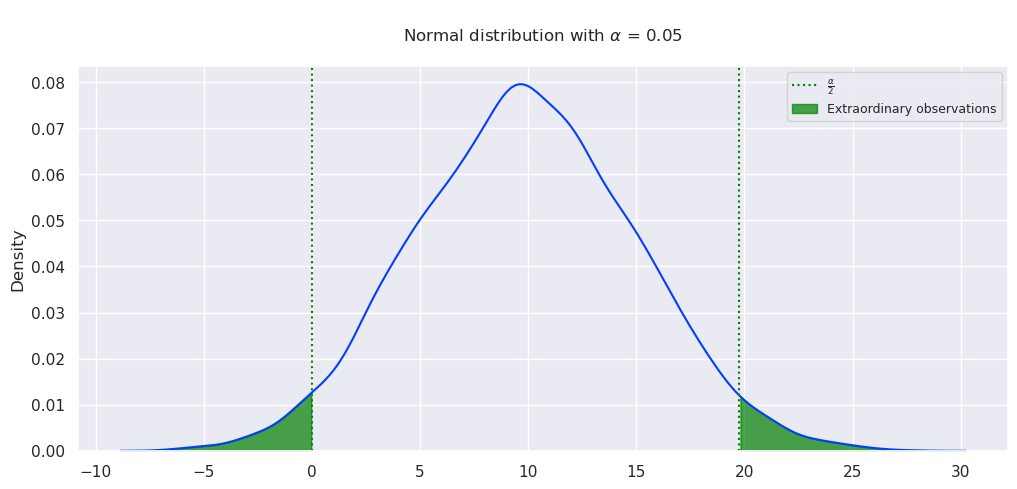

In [17]:
# Plotting distribution and tails

plt.figure(figsize=(12,5))
axis = sns.kdeplot(normal)
axis.axvline(left_tail, linestyle="dotted", color="green", label=r"$\frac{\alpha}{2}$")
axis.axvline(right_tail,linestyle="dotted", color="green")

# values equal or lower than alpa
X,Y = axis.get_lines()[0].get_data()
mask_left = (X <= left_tail)
mask_right= (X >= right_tail)

axis.fill_between(x=X[mask_left], y1=Y[mask_left], color="green", alpha=0.7, label="Extraordinary observations")
axis.fill_between(x=X[mask_right], y1=Y[mask_right], color="green", alpha=0.7)

axis.legend(fontsize=9)
plt.title(f"\nNormal distribution with $\\alpha$ = {alpha_tail * 2}\n")
plt.show()

In [18]:
# USING THE EXAMPLE ABOVE (PLOT)....
# The p_value is the probability of getting the same or even rarer observations of you data point, for example,
# the probability of getting a value of x=5 or rarer means getting a value of 5 or 4, or 3 etc. Likewise,
# It also encompass getting values of 15 or 16 or 17 etc. Because values of x greater than 15 (kind of) has the same
# probability of getting a value of 5 and we also take into account stranger observations

adjusted_curve = stats.norm(loc=normal.mean(), scale=normal.std())

# Probability of getting equal or rarer values of x=5 (cumulative density function of 5 of only one tail)
x = 5
p_value_left = adjusted_curve.cdf(x)

# The symmetric nature of normal distribution makes simple to get the probability of the right tail
p_value = p_value_left * 2

print(f"\nThe p-value of getting the same or rarer observation of our value chosen '{x}' is {p_value}\n")


The p-value of getting the same or rarer observation of our value chosen '5' is 0.33556207548440253



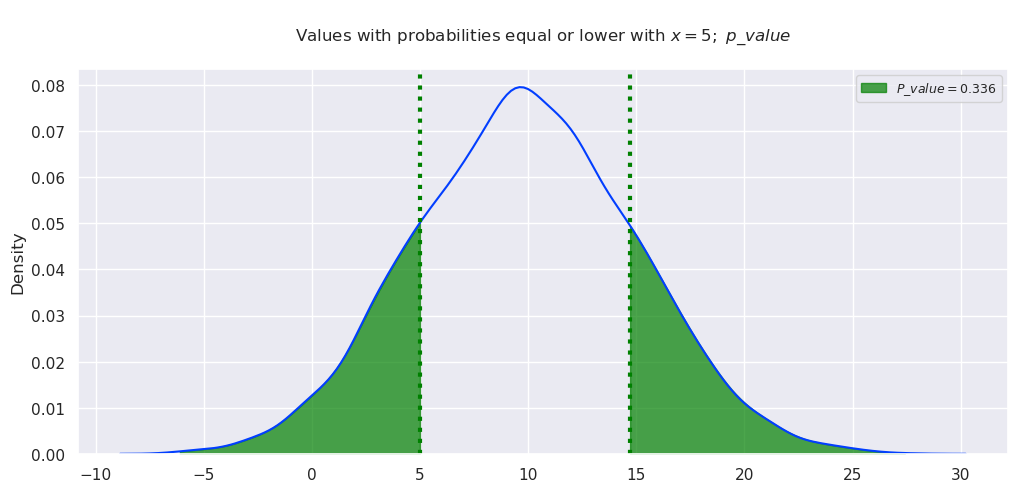

In [19]:
# As you saw above, a probability of 0.3 is not such a rare thing, It's pretty common, therefore our value of x=5
# is not special as you could think. There is even stranger observations

# Getting the exact symmetric value of x on the right tail
right_tail_value_percentile = 100 - stats.percentileofscore(normal, x)
right_tail_value = np.percentile(normal, right_tail_value_percentile)

# Estimating density of the plot because seaborn sometimes is not as good as sklearn
# This is usefull to fill under the curve the plot below
normal_copy = normal.reshape(-1,1)
samples_x_left  = np.arange(min(normal_copy), x, 0.1).reshape(-1, 1)
samples_x_right = np.arange(right_tail_value, max(normal_copy), 0.1).reshape(-1, 1)

kernel_density_object = KernelDensity().fit(normal_copy)
samples_y_left  = np.exp(kernel_density_object.score_samples(samples_x_left))
samples_y_right = np.exp(kernel_density_object.score_samples(samples_x_right))

# Plotting distribution and tails

plt.figure(figsize=(12,5))
axis = sns.kdeplot(normal_copy)
axis.axvline(x, linestyle="dotted", color="green", linewidth=3)
axis.axvline(right_tail_value, linestyle="dotted", color="green", linewidth=3)

# values equal or lower than x (in this case it was 5)
axis.fill_between(x=samples_x_left.reshape(-1,), y1=samples_y_left.reshape(-1,),
                  color="green", alpha=0.7,
                  label=f"$P\_value={round(p_value, 3)}$")
axis.fill_between(x=samples_x_right.reshape(-1,), y1=samples_y_right.reshape(-1,),
                  color="green", alpha=0.7)

axis.legend(fontsize=9)
plt.title(f"\nValues with probabilities equal or lower with $x={x};\ p\_value$\n")
plt.show()

### Parametric test

Parametric tests are those statisctic tests that make assumptions about the parameters of the population distribution (usually normally distributed) from wich the sample is drawn. In such way, We are able to see in this category some of the following test

* T-test
* Z-test
* Anova
* Ancova
* Manova
* Mancova

Every test shown above is used on different sceneries according to the data used, sample size and purpose of the research. Also, it's worth to note that every test produce a value which needs to be compared to the distribution of the repective test to get the right p-value and, therefore, reject or not the null hypotesis

#### T-test

This parametric test is used to compare the means between two groups (It determines if the means of the two groups are equal between each other).

T-test or Student's t-test is used when the standard deviation of the population is unknown and/or the sample size is lower than 30 (rule of thumb). T-test assumes the following about your data

1. The sample data have been randomly sampled from a population.
2. There is homogeneity of variance (i.e., the variability of the data in each group is similar).
3. The distribution is approximately normal.

The second point discussed above is not exactly true because there is a t-test for samples with unequal variances. In this way, there are 3 t-tests trying to answer different questions.

* T-test paired (within-subject design): A T-test paired is used If the groups come from the same population (i.e., measure before and after a group under a experimental treatment) 

* T-test of two-samples or independent t-test (between-subjects design): A two-samples T-test is used if two groups come from different populations (i.e., two species or two groups of people from different cities). Independet T-test has two elemental variants. An independent T-test for samples with equal size and variance and an independent T-test for samples with equal or unequal sample size and unequal variances (This is also called a welch's test) 

* One sample T-test: If we only have one group that is compared to a single value, we use one-sample T-test.

On the other hand, we also need to remember those tests can be applied to one-tailed and two-tailed experiments.

__T-test paired__

$$T = \frac{mean_1 - mean_2}{\frac{s(diff)}{\sqrt(n)}}$$

$$s(diff)=standard\ deviation\ of\ the\ paired\ differences\ of\ the\ samples$$

$$degree\ of\ freedom\ or\ df= n -1$$

__One sample T-test__

$$T = \frac{\overline{x} - \mu_0}{\frac{s}{\sqrt{n}}}$$

$$\overline{x}=mean\ of\ the\ sample$$
$$\mu_0 = value\ to\ compare$$
$$s = standard\ deviation$$
$$df=n-1$$

__Independent T-test or two-samples T-test__

_Equal variances_

$$T = \frac{\overline{x_1} - \overline{x_2}}{Sp \sqrt{\frac{1}{n_1} + \frac{1}{n_2}}}$$

$$Sp=\sqrt{  \frac{(n_1 - 1)s_1^2 + (n_2 - 1)s_2^2}{n_1 + n_2 -2}}$$

$$s_1; s_2 = standard\ deviation$$
$$df= n_1 + n_2 - 2$$


_Unequal size and unequal variances (also called welch's t-test)_

$$T =  \frac{\overline{x_1} - \overline{x_2}}{\sqrt{\frac{s_1^2}{n_1} + \frac{s_2^2}{n_2}}}$$

$$s_1;s_2 = standard\ deviation$$

$$df = \frac{(\frac{s_1^2}{n_1} + \frac{s_2^2}{n_2})^2}{\frac{1}{n_1 - 1}(\frac{s_1^2}{n_1})^2 + \frac{1}{n_2 - 1}(\frac{s_2^2}{n_2})^2}$$

$$s_1;s_2 = standard\ deviation$$


You probably noticed something called degrees of freedom, in a nutshell, the distribution curve as the sample size decreases changes, this translates as longer and wider tails and a less high peak. Therefore, this curve of our statistic has to be refined according to the sample size, and this is what the degrees of freedom are for.

##### F-test

I mentioned earlier that in order to perform a t-test there must be homogeneity of variance. An F-test is a popular test to assay it.

F-test is usually (but not limited) to assays the variance among two variables and it's sensitive to non-normal data. The null hypotesis states equal variance for the two samples $var_1 = var_2$ and the alternative hypotesis of two-tailed is $var_1 \ne var_2$.

$$
F = \frac{\sigma_1^2}{\sigma_2^2}\ \ \ \ \ \ \ \sigma_1^2;\sigma_2^2 = variances\ of\ the\ population\ or\ the\ samples
$$

Depending if the test is set to two-tailed, right-tailed or left-tailed. The order to determine $\sigma_n^2$ vary. For intance, a two-tailed or right-tailed the larger variance between the samples is set to be the numerator, instead in a left-tailed, the smaller value of the variance becomes the numerator.

Other tests to check for homogeneity of variances usually used (sometimes even refered as "more powerfull than the F-test") are levene's test and Barlett test. Those are not going to be discussed in more detail here but It's good to know that they exist.

In [20]:
# Loading dataset
iris_df = sns.load_dataset("iris")
iris_df.sample(10)

sepal_length  sepal_width  petal_length  petal_width     species
66            5.6          3.0           4.5          1.5  versicolor
47            4.6          3.2           1.4          0.2      setosa
136           6.3          3.4           5.6          2.4   virginica
105           7.6          3.0           6.6          2.1   virginica
18            5.7          3.8           1.7          0.3      setosa
59            5.2          2.7           3.9          1.4  versicolor
53            5.5          2.3           4.0          1.3  versicolor
32            5.2          4.1           1.5          0.1      setosa
102           7.1          3.0           5.9          2.1   virginica
132           6.4          2.8           5.6          2.2   virginica

In [21]:
# Filtering samples of setosa and virginica for sepal_length
setosa_df = iris_df.loc[iris_df["species"] == "setosa", :].sepal_length
virginica_df = iris_df.loc[iris_df["species"] == "virginica", :].sepal_length

# Sampling 30 observations to test if the means between the two species are differents (using independent t-test)
sample_size = 30
setosa_sample = setosa_df.sample(sample_size, random_state=42)
virginica_sample = virginica_df.sample(sample_size, random_state=42)

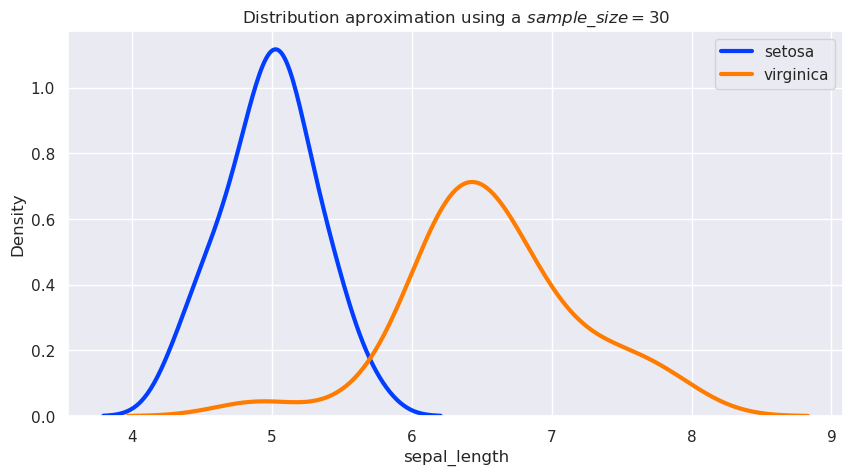

In [22]:
plt.figure(figsize=(10,5))
sns.kdeplot(setosa_sample, label="setosa", linewidth=3)
sns.kdeplot(virginica_sample, label="virginica", linewidth=3)
plt.legend()
plt.title(f"Distribution aproximation using a $sample\_size={sample_size}$")
plt.show()

In [23]:
# Both samples seems normal and obviously the populations differs but, anyway let's do a t-test.
# First let's check if the variances are equal or not using F-test of two-tailed
# H0 = There are no differences between the variances var_1 = var_2 if p>0.05
# H1 = There is a difference between the variances var_1 != var_2   if p<0.05

def Ftest(sample1:"array-like", sample2:"array-like") -> (float, float):
    
    '''
    F-test of the variance
    
    This function does the two-tailed F-test to compare the variance between two populations with null
    hypotesis (H0) describing equal variances and alterntive hypotesis (H1) for unequal variances
    
    Paramaters
    ----------
    
    sample1: array-like
        Sample of the first population
        
    sample2: array-like
        Sample of the second population

    Return
    ------
        (float, float): F-statistic and p_value respectively
    
    Examples
    --------
    
    >>>import scipy.stats as stats
    >>>import numpy as np
    >>>sample_A = [1,2,3,4,5]
    >>>sample_B = [1,2,4,4,5]
    >>>Ftest(sample_A, sample_B)
    (1.08, 0.9423361401911694)
    '''
    
    # Variance of the samples
    sigma_1 = np.var(sample1, ddof=1)
    sigma_2 = np.var(sample2, ddof=1)
    
    numerator, denominator = (sigma_1, sigma_2) if sigma_1 > sigma_2 else (sigma_2, sigma_1)
    F = numerator / denominator

    p_value_one_tailed = 1 - stats.f.cdf(F, np.size(sample1) - 1, np.size(sample2) - 1)
    
    return F, p_value_one_tailed * 2

In [24]:
def ShowTypeVariances(p, alpha, statistic):
    
    print(f'{statistic[0]}: statistic = {statistic[1]}; p_value = {p}')
    
    if p < alpha:
        print("\tThe variances are not equal")
    else:
        print("\tThe variances are equal")

alpha = 0.05
F_statistic, p_value_F = Ftest(setosa_sample, virginica_sample)
ShowTypeVariances(p_value_F, alpha, ["F-test", F_statistic])

F-test: statistic = 3.391227706345914; p_value = 0.001539251598021929
	The variances are not equal


In [25]:
# We'll make also levene and barlett tests using the same alpha

levene_statistic, p_value_l  = stats.levene(setosa_sample, virginica_sample)

# Barlett is more sensitive to non-normal data. Only used if we are really confident that the
# data is normal
barlett_statistic, p_value_b = stats.bartlett(setosa_sample, virginica_sample)

ShowTypeVariances(p_value_l, alpha, ["Levene-test", levene_statistic])
ShowTypeVariances(p_value_b, alpha, ["Barlett-test", barlett_statistic])

Levene-test: statistic = 4.564968517458503; p_value = 0.0368626178547197
	The variances are not equal
Barlett-test: statistic = 10.027323487542784; p_value = 0.0015423499256511143
	The variances are not equal


In [26]:
# The variances are not equal as you already see, therefore;
# we will use an t-test for unequal variances (welch's test)
independet_ttest = stats.ttest_ind(setosa_sample, virginica_sample, equal_var=False)

if independet_ttest.pvalue < alpha:
    print("The means between setosa and virginica are statistically different (mu_1 != mu_2)")
else:
    print("The means between setosa and virginica are statistically equal (mu_1 = mu_2)")

The means between setosa and virginica are statistically different (mu_1 != mu_2)


An independent t-test for two species was done with unequal variances. However, using ```stats.ttest_rel``` we are able to run a paired-sample t-test and ```stats.ttest_1samp``` for one sample and by means of the parameter _alternative_ choose among two-tailed, right or left tail.

#### Z-test

Z-test is another parametric test to compare means between groups, more formally internet says "z-test is a statistical test to determine whether two population means are different when the sample size is large and the variances are known" As with a T-test to compare means, a Z-test has the same function but assumes that we do know the standard deviation about the population from which the sample came and that it follows a normal distribution. Similarly, a Z-test can be performed one-sample and for two independent samples, either two-tailed or one-tailed.

__Two-sample__

$$z = \frac{\overline{x_1}\ –\ \overline{x_2}}{ \sqrt{\frac{\sigma_1^2}{n_1} + \frac{\sigma_2^2}{n_2}}}$$

$$\sigma_1;\sigma_2=population\ standard\ deviations$$
$$\overline{x_1};\overline{x_2}=sample\ means$$

__One-sample__

$$Z=\frac{(\overline{X}-\mu_{0})}{\sigma}$$

$$\overline{X}=mean\ of\ the\ sample$$
$$\mu_{0}=mean\ to\ compare$$
$$\sigma=population\ standard\ deviation$$

In addition, a Z-test can be applied for two proportions

$$Z = \frac{\hat{p}_1 - \hat{p}_2}{\sqrt{\hat{p}(1 - \hat{p})(  \frac{1}{n_1} + \frac{1}{n_2})}}$$

$$\hat{p}_1;\hat{p}_2 =proportions\ of\ samples$$
$$\hat{p}=mean\ of\ both\ samples$$


#### T-test vs Z-test

Both tests are used for comparison of means for normal data, but which one to use? Well, one may find that for sample sizes smaller than 30 a t-test seems to be used almost exclusively, while for those larger than that, a Z-test must be your choice regardless of whether or not the population standard deviation is known. This makes sense in light of the fact that a standard distribution T becomes more similar to the Z-distribution as the number of the sample size increases (central limit theorem) and the standard deviation of the population can be aproximated with the sample (that's the reason why in some notations of the Z-test you will find the formula using the difference of the means divided by the standard error of the sample instead of the standard deviation of the population, similar in the one-sample t-test does). However, strictly speaking some mention that if your sample size is larger than 30 and you do NOT know the variance or standard deviation of the population you would be making a mistake (not a big one actually) when using a Z-test, since you will get a slight error in the statistics obtained.

As mentioned earlier, the distribution curve changes with respect to the sample number, that is why a few degrees of freedom are defined for the t-test, which is not necessary for a Z distribution. The lower the degrees of freedom, a curve with wider tails is obtained, as the degrees tend to infinity, a Z-distribution will be obtained (with flatter tails).

Apparently the use of a Z-test when the sample size is greater than 30 has a historical connotation, not all statisticians had access to tables of p-value probabilities for all degrees of freedom, as opposed to a table for the Z distribution (again, where degrees of freedom are not necessary) and, since both are similar as the sample size increases, it was ok.

With that small reflection, nowadays we have programs with all those values calculated and therefore, in my personal understanding, independently of the sample size, if we do not know the standard deviation of the population we should NOT use a Z-test, but a t-test. But on the other hand, if these calculations are done manually, then it may be convenient to use a Z-test just for ease, with a minimal error that can sometimes be negligible.

In [27]:
## Let's calculate a Z-test of the following problem found on internet (from
# youtube channel statslectures)

# In the population, the average IQ is 100 with a standard deviation of 15. A team
# of scientists wants to test a new medication to see if it has either a positive or
# negative effect on intelligence, or no effect at all. A sample of 30 participants who
# have taken the medication has a mean of 140. Did the medication affect intelligence?

# Notes
# 1. This is a two-tailed problem because the exercise states for either a negative or positive effect,
#    not only for a positive effect (right tail) or only a negative effect (left tail)
# 2. This a one sample Z-test because we are comparing a sample versus a given value. We are not comparing
#    two samples or two populations
# 3. Let's set a confidence level of 95% or alpha of 0.05
#
# H0: There is no difference between the IQ mean of the participants (X_1 = 140) and the IQ of (X_2 = 100)
#      X_1 = X_2
# H1; There is a difference between the IQ mean of the participants (X_1 = 140) and the IQ of (X_2 = 100)
#       X_1 != X_2

std_population = 15
participants_mu = 100
mu_value = 140
alpha = 0.05

Z_statistic = (participants_mu - mu_value) / std_population
Z_distribution = stats.norm(loc=0, scale=1)

p_value_one_tail = Z_distribution.cdf(Z_statistic)
p_value_two_tail = p_value_one_tail * 2

if p_value_two_tail < alpha:
    print("The drug had an effect on the participants c: !")
else:
    print("The frug had no effect on the participants :c ")

print(f"p_value: {p_value_two_tail}")

The drug had an effect on the participants c: !
p_value: 0.007660761135179473


In [28]:
# On the other hand, here we have an interactive graphic representation of the
# Z-distribution (standard normal distribution) and t-distribution using
# different degrees of freedom. It's easier to plot using a data frame (no preview on github)

def t_distribution_standard(df, x):
    return stats.t.pdf(x=x, df=df, loc=0, scale=1)

# Range of values to retrieve density of Z-distribution and T-distribution
x_values = np.arange(-5, 5.025, 0.025)

# Normal data for plotting
normal_distribution_plot = stats.norm.pdf(x=x_values, loc=0, scale=1)

t_distributions = np.empty((x_values.shape[0], 3))
df_t_distributions = pd.DataFrame()

# Retrieving the density of t-distributions based on the degrees
for degree in range(1, 31):

    t_distributions[:,0] = degree
    t_distributions[:,1] = x_values.copy()
    t_distributions[:,2] = t_distribution_standard(degree, x_values)
    
    df_t_distributions = pd.concat([df_t_distributions, pd.DataFrame(t_distributions)])
    
df_t_distributions.rename({0:"Degree", 1:"Std", 2:"Density"}, inplace=True, axis=1)
df_t_distributions["Degree"] = df_t_distributions["Degree"].transform(int)

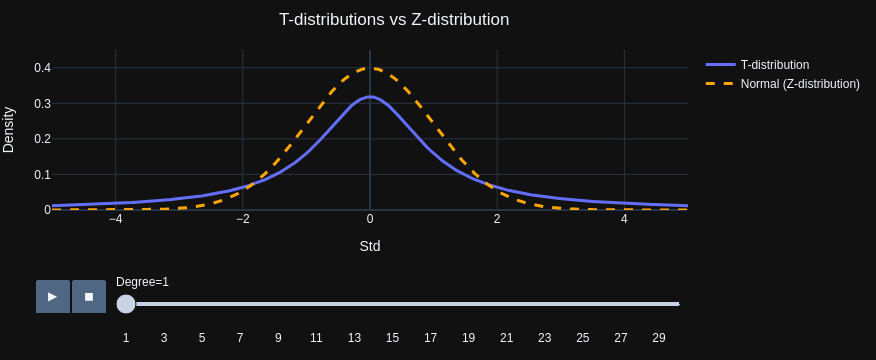

In [29]:
fig = px.line(df_t_distributions, x="Std", y="Density",
                 animation_frame="Degree", range_y=[0,0.45],
                 template="plotly_dark")

fig.update_traces(line=dict(width=3), name="T-distribution", showlegend=True)
fig.update_layout(title_text='T-distributions vs Z-distribution', title_x=0.45)

fig.add_scatter(x=x_values, y=normal_distribution_plot,
                line=dict(width=3,
                          color="orange",
                          dash="dash"),
                name="Normal (Z-distribution)",
                hovertemplate='Std=%{x}<br>Density=%{y}'
               )

fig.update_layout(
    margin=dict(l=30, r=150, t=50, b=10),
)


#fig["layout"].pop("updatemenus")
fig.show()

#### Anova

Before starting, a more detailed description of this statistical test can be found in [ANOVA análisis de varianza para comparar múltiples medias por
Joaquín Amat Rodrigo](https://www.cienciadedatos.net/documentos/19_anova#Tama%C3%B1o_del_efecto_(eta^2)) from which most of the following explanations/examples are derived.

In brief, Anova is a set of statistical tests used to compare the mean between two or more groups. Similar to a t-test, Anova introduces three main types of analysis.

* One-way Anova to compare the means between more than two groups with one factor and one response variable (e.g., the response to a (quantitative) drug to improve concentration at different ages [for children, adults or the elderly]).

* Anova for multiple factors and one response such as two-way, three-way etc. (e.g., response to a drug (quantitative) to improve concentration in different sexes [for male or female] of different ages [for children, adults, or elderly])

* Anova for dependent, paired or repeated data (e.g., response to a drug (quantitative) to improve concentration before and after the intake for different ages [for children, adults or elderly])

In general, those tests share some assumptions

* Independence: The observations must be random and the groups or factors independent of each other (assumption not valid for repeated data ANOVA).

* Homoscedasticity: The variance within groups should be approximately equal in all of them (assumption not valid for heterodastic ANOVA using Welch correction or Welch test).

* Normal distribution between groups

In turn, each of the above Anovas tests may have fewer or additional assumptions.

The statistic obtained by an Anova test is the $F_{ratio}$ which follows a "Fisher-Snedecor F" distribution and was developed under the null hypothesis that the mean between all the groups studied is the same or there is no difference, also denoted as $\mu_1 = \mu_2 = \mu_3 ...... = \mu_n$, on the contrary, the alternative hypothesis states that the mean of at least two groups differ significantly. Note, therefore, that an Anova test does not tell us which of these groups' means were different. For this purpose, post-hoc methods (methods after rejecting the null hypothesis) such as the Tukey-Kramer Honest Significant Difference (HSD) or paired t-test comparisons with corrections to avoid type I error inflation such as the Holm-Bonferroni Adjustment are used.

For the calculation of one-way ANOVA the intervariance and intravariance must be found. Those calculations are often decomposed into the calculation of Sum of Squares due to Treatment or (SSF) or sum of squares between the groups (SSB), Sum of Squares of Errors (SSE) or sum of squares within the groups (SSB) and Total Sum of Squares (TSS). Each calculated as:

| Source of variation |              Sum of Squares              | Degrees of Fredom |       Mean Squares       |            F           |
|:-------------------:|:----------------------------------------:|:-----------------:|:------------------------:|:----------------------:|
|    Between Groups   | $$SSB=\sum n_j(\bar{x}_j - \bar{x})^2$$  |  $$df_b = k - 1$$ |$$MSB = \frac{SSB}{df_b}$$| $$F = \frac{MSB}{MSE}$$|
|        Error        |    $$SSE = \sum \sum (x - \bar{x}_j)^2$$ |  $$df_e = N - k$$ |$$MSE = \frac{SSE}{df_e}$$|                        |
|        Total        |              $$SST = SSB + SSE$$         |  $$df_t = N - 1$$ |                          |                        |

Additionally, based on SSW and SSB, the mean squares (MS) are calculated and divided to obtain the F_{ratio}. The meaning of the variables is as follows:

$X=Values\ across\ each\ group$

$\bar{X}_j=Mean\ of\ each\ group$

$\bar{X}=Grand\ mean\ or\ general\ mean\ across\ all\ groups$

$k=Number\ of\ groups$

$n_j=Total\ observations\ across\ each\ group$

$N=Total\ observations\ across\ all\ groups$

Meanwhile, a statistic that accompanies an ANOVA test is the effect size. Several methods to calculate the effect size has been developed, one of them is denoted as $\eta^2$ and this is the value that allows measuring how much variance in the quantitative dependent variable is the result of the influence of the independent qualitative variable, or what is the same, how much the independent variable (factor) affects the dependent variable and is calculated as:

$$\eta^2 = \frac{SS_{effect}}{SS_{total}}$$

$$SS_{effect}= The\ sum\ of\ squares\ of\ an\ effect\ for\ one\ variable$$
$$SS_{total}= The\ total\ sum\ of\ squares\ in\ the\ ANOVA\ model$$

The most commonly used classification levels for effect size are:

$$0.01 = small$$
$$0.06 = medium$$
$$0.14 = large$$

##### One-way Anova in R

To run a one-way anova test in R we'll use the function ```aov```

In [30]:
%%R

# Three different traffic routes are tested for mean driving time.
# Suposse we want to know if there is a difference among the average time
# in those routes

Route_1 <- c(30,32,27,35)
Route_2 <- c(27,29,28,36)
Route_3 <- c(16,41,22,31)

Values <- c(Route_1, Route_2, Route_3)
Routes <- rep(c("Route_1","Route_2","Route_3"), c(length(Route_1),length(Route_2),length(Route_3)))

data_routes <- data.frame(Values, Routes)

# Let's check for normality plotting and doing the shapiro-wilk test
# H0 = There is no difference between a normal curve and the data x if p>0.05
# H1 = There is a difference between a normal curve and the data x if p<0.05
by(data_routes, Routes, FUN = function(x){ shapiro.test(x$Values) } )

Routes: Route_1

	Shapiro-Wilk normality test

data:  x$Values
W = 0.99994, p-value = 0.9999

------------------------------------------------------------ 
Routes: Route_2

	Shapiro-Wilk normality test

data:  x$Values
W = 0.80689, p-value = 0.1152

------------------------------------------------------------ 
Routes: Route_3

	Shapiro-Wilk normality test

data:  x$Values
W = 0.97729, p-value = 0.8859



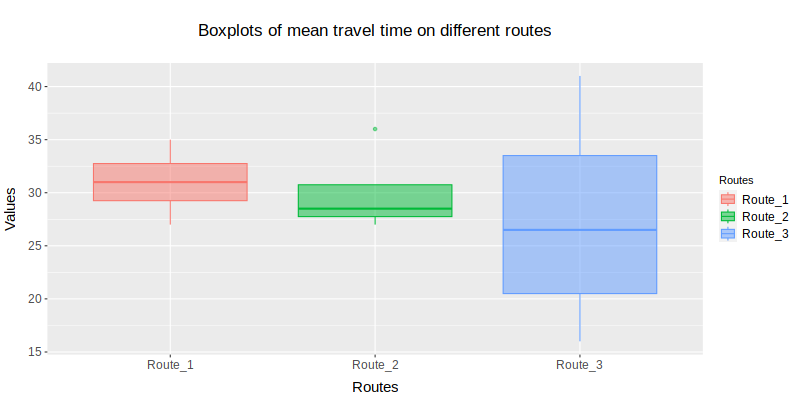

In [31]:
%%R --height=400 --width=800

# Boxplots
ggplot(data_routes, aes(x=Routes, y=Values)) + 
    geom_boxplot(aes(color=Routes, fill=Routes), alpha=0.5) + 
    ggtitle("\nBoxplots of mean travel time on different routes\n") + 
    
    # Resizing all text elements
    theme(plot.title = element_text(hjust = 0.5, size=17),
          axis.text = element_text(size=12), 
          axis.title = element_text(size=15),
          axis.title.x = element_text(margin = margin(t = 10, r = 0, b = 0, l = 0)),
          axis.title.y = element_text(margin = margin(t = 0, r = 10, b = 0, l = 0)),
          legend.text = element_text(size=12)
         )

According to the Shapiro-Wilk test, there is no difference among the routes and a normal curve; therefore, we can say the data follows a normal distribution. However, the boxplot points out an outlier for the second Route and this is probably the reason of the low p-value obtained for the shapiro-wilk test, we are not removing this to maintain balanced classes for the sake of this exercise.

Also the sizes of the boxes indicate a difference in the range of values obtained and this is going to be reflected in the variance (no homoscedasticity) among the groups. Let's found out by using a levene test.

In [32]:
%%R

# Using levene test for homogeneity by median and alpha=0.05
# H0: There are no differences among variances if p>0.05
# H1: THere are differences among variances if p<0.05
leveneTest(Values ~ Routes,data_routes, center = "median")

Levene's Test for Homogeneity of Variance (center = "median")
      Df F value  Pr(>F)  
group  2  3.7565 0.06514 .
       9                  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


Since the p_value > 0.05, we cannot reject the null hypothesis and the variances are equal, it means we don't need to adjust an ANOVA test for unequal variances. Nevertheless, we are almost at the limit to reject or not the null hypothesis and using a different metric as the mean and because we are including our outlier for the route_2, this could be a different story.

Now It's time to run the anova test for one way. The only factor we have is the variable Route, the data is normally distributed and also the variances are equal. To acomplish this, the one-way ANOVA of is done with ```aov``` function in R

In [33]:
%%R

# one-way Anova
# H0: Equal means among the groups mu_1 = mu_2 = mu_3 ... = mu_n if p_value>0.05
# H1: At least two groups have different means if p_value<0.05

one_way_anova <- aov(Values ~ Routes, data_routes)
one_way_summ <- summary(one_way_anova)
one_way_summ

            Df Sum Sq Mean Sq F value Pr(>F)
Routes       2     26      13   0.265  0.773
Residuals    9    441      49               


As you can see, we cannot reject the null hypothesis, so we conclude the means across all groups are the same. In this way, a post-hoc method is not necessary. 

On the other hand, lets calculate the $\eta^2$ using ```etaSquared``` from the _lsr_ package. We can also calculate it manually using the sum of squares

In [34]:
%%R
etaSquared(one_way_anova)

           eta.sq eta.sq.part
Routes 0.05567452  0.05567452


In [35]:
%%R
one_way_summ[[1]]["Sum Sq"][[1]][1] / sum(one_way_summ[[1]]["Sum Sq"])

[1] 0.05567452


We have an $\eta^2=0.055$, an effect size of about medium

##### Two-way Anova

The two-way Anova states a different null hypothesis that the one-way version does. The two-way ANOVA with replications combines 3 null hypotheses

* The means of the observations grouped by one factor are equal
* The means of the observations grouped by the other factor are equal
* There is no interaction between the two factors or the effect of one independent variable does not depend on the effect of the other independent variable

Two-way Anova is done by calling the function ```aov``` indicading the two categorical groups for an additive model "$+$" (handle the two variables independently) or an interaction effect model "$*$" (handle the two variables with a dependent relation)

In [36]:
%%R

# A building materials company wants to study the influence of thickness and type
# of tempering on the ultimate strength of steel sheets. For this purpose,
# they measure the stress to rupture (quantitative dependent variable) for two 
# types of tempering (slow and fast) and three sheet thicknesses (8 mm, 16 mm and 24 mm).

Strength <- c(15.29, 15.89, 16.02, 16.56, 15.46, 16.91, 16.99, 17.27, 16.85,
                 16.35, 17.23, 17.81, 17.74, 18.02, 18.37, 12.07, 12.42, 12.73,
                 13.02, 12.05, 12.92, 13.01, 12.21, 13.49, 14.01, 13.30, 12.82,
                 12.49, 13.55, 14.53)

Tempering <- c("Fast","Fast","Fast","Fast","Fast","Fast","Fast","Fast","Fast","Fast",
                "Fast","Fast","Fast","Fast","Fast","Slow","Slow","Slow","Slow","Slow",
                "Slow","Slow","Slow","Slow","Slow","Slow","Slow","Slow","Slow","Slow")

Thickness <-  c(8,8,8,8,8,16,16,16,16,16,24,24,24,24,24,8,8,8,8,8,16,16,16,16,16,24,24,24,24,24)

steel_sheets <- data.frame(Tempering, Thickness=as.factor(Thickness), Strength)
head.matrix(steel_sheets)

  Tempering Thickness Strength
1      Fast         8    15.29
2      Fast         8    15.89
3      Fast         8    16.02
4      Fast         8    16.56
5      Fast         8    15.46
6      Fast        16    16.91


In [37]:
%%R
# Class distributions
table(steel_sheets["Tempering"])

Tempering
Fast Slow 
  15   15 


In [38]:
%%R
# Class distributions
table(steel_sheets["Thickness"])

Thickness
 8 16 24 
10 10 10 


In [39]:
%%R
# Class distributions
table(steel_sheets[c("Tempering","Thickness")])

         Thickness
Tempering 8 16 24
     Fast 5  5  5
     Slow 5  5  5


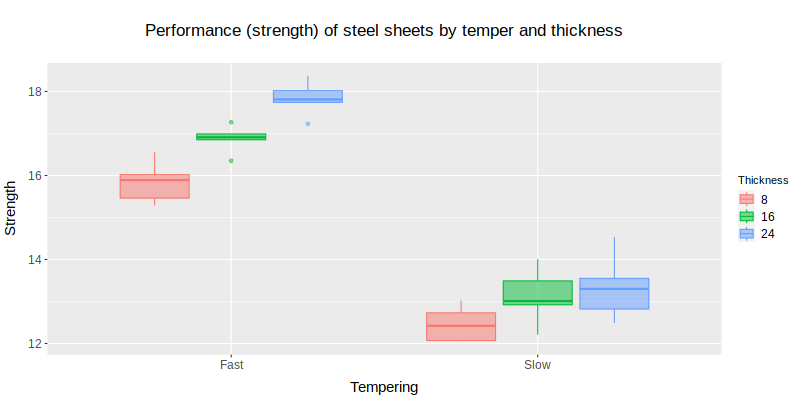

In [40]:
%%R --height=400 --width=800

# Boxplots
ggplot(steel_sheets, aes(x=Tempering, y=Strength, color=Thickness, fill=Thickness)) + 
    geom_boxplot(alpha=0.5) + 
    ggtitle("\nPerformance (strength) of steel sheets by temper and thickness\n") + 
    
    # Resizing all text elements
    theme(plot.title = element_text(hjust = 0.5, size=17),
          axis.text = element_text(size=12), 
          axis.title = element_text(size=15),
          axis.title.x = element_text(margin = margin(t = 10, r = 0, b = 0, l = 0)),
          axis.title.y = element_text(margin = margin(t = 0, r = 10, b = 0, l = 0)),
          legend.text = element_text(size=12)
         )

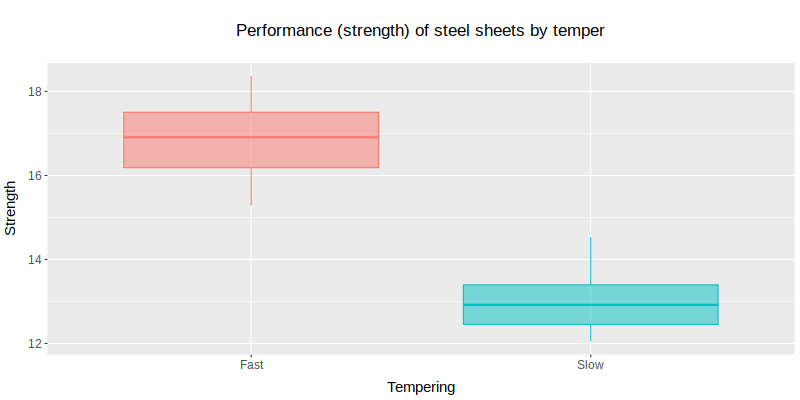

In [41]:
%%R --height=400 --width=800

# Boxplots
ggplot(steel_sheets, aes(x=Tempering, y=Strength, color=Tempering, fill=Tempering)) + 
    geom_boxplot(alpha=0.5, show.legend = FALSE) + 
    ggtitle("\nPerformance (strength) of steel sheets by temper\n") + 
    
    # Resizing all text elements
    theme(plot.title = element_text(hjust = 0.5, size=17),
          axis.text = element_text(size=12), 
          axis.title = element_text(size=15),
          axis.title.x = element_text(margin = margin(t = 10, r = 0, b = 0, l = 0)),
          axis.title.y = element_text(margin = margin(t = 0, r = 10, b = 0, l = 0)),
         )

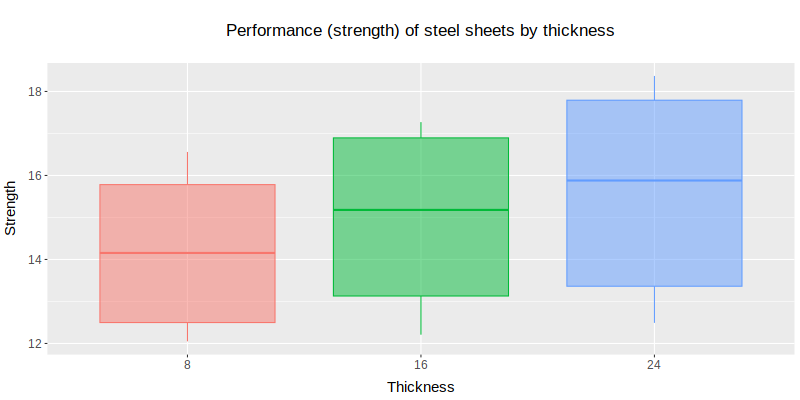

In [42]:
%%R --height=400 --width=800

# Boxplots
ggplot(steel_sheets, aes(x=Thickness, y=Strength, color=Thickness, fill=Thickness)) + 
    geom_boxplot(alpha=0.5, show.legend = FALSE) + 
    ggtitle("\nPerformance (strength) of steel sheets by thickness\n") + 
    
    # Resizing all text elements
    theme(plot.title = element_text(hjust = 0.5, size=17),
          axis.text = element_text(size=12), 
          axis.title = element_text(size=15),
          axis.title.x = element_text(margin = margin(t = 10, r = 0, b = 0, l = 0)),
          axis.title.y = element_text(margin = margin(t = 0, r = 10, b = 0, l = 0)),
         )

In [43]:
%%R
# Let's do the anova test for an interactive model (sign * in formula)
# We'll check normality later using the Residuals. It's easier than trying 
# a shapiro test directly. The residuals should follow a normal distribution

# Formula to use in both anova and levene
fml <- as.formula("Strength ~ Tempering * Thickness")
leveneTest(fml, steel_sheets)

Levene's Test for Homogeneity of Variance (center = median)
      Df F value Pr(>F)
group  5  0.6939 0.6331
      24               


In [44]:
%%R
anova_two_way <- aov(fml, steel_sheets)
summary(anova_two_way)

                    Df Sum Sq Mean Sq F value   Pr(>F)    
Tempering            1 112.68  112.68 380.082 3.19e-16 ***
Thickness            2  10.41    5.21  17.563 2.00e-05 ***
Tempering:Thickness  2   1.60    0.80   2.705   0.0873 .  
Residuals           24   7.11    0.30                     
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [45]:
%%R
etaSquared(anova_two_way)

                        eta.sq eta.sq.part
Tempering           0.85485219   0.9406061
Thickness           0.07900327   0.5940887
Tempering:Thickness 0.01216553   0.1839235


The analysis of variance confirms that there is a significant influence on sheet strength by both Tempering and Thickness with large (0.85) and medium (0.079) $\eta^2$ effect sizes respectively, meaning at least two groups there had different means. In addition, no significant interaction between them was found (Tempering:Thickness with p_value = 0.0873 using an $\alpha=0.05$), wich means we only need to check for normality for the results to be valid.

In [46]:
%%R
resid <- residuals(anova_two_way)
shapiro.test(resid)


	Shapiro-Wilk normality test

data:  resid
W = 0.98397, p-value = 0.9185



Finally to end this section, Which groups are the ones that differ in their mean? Let's run a Tukey-Kramer Honest Significant Difference (HSD) test and a paired t-test with the Holm-Bonferroni Adjustment (this one only for combinations of Tempering and Thickness, but not both)

In [47]:
%%R
anova_two_way_tukey <- TukeyHSD(anova_two_way)
anova_two_way_tukey

  Tukey multiple comparisons of means
    95% family-wise confidence level

Fit: aov(formula = fml, data = steel_sheets)

$Tempering
            diff      lwr      upr p adj
Slow-Fast -3.876 -4.28633 -3.46567     0

$Thickness
       diff         lwr      upr     p adj
16-8  0.850  0.24192212 1.458078 0.0051615
24-8  1.435  0.82692212 2.043078 0.0000129
24-16 0.585 -0.02307788 1.193078 0.0609253

$`Tempering:Thickness`
                  diff         lwr      upr     p adj
Slow:8-Fast:8   -3.386 -4.45072028 -2.32128 0.0000000
Fast:16-Fast:8   1.030 -0.03472028  2.09472 0.0619831
Slow:16-Fast:8  -2.716 -3.78072028 -1.65128 0.0000006
Fast:24-Fast:8   1.990  0.92527972  3.05472 0.0000783
Slow:24-Fast:8  -2.506 -3.57072028 -1.44128 0.0000022
Fast:16-Slow:8   4.416  3.35127972  5.48072 0.0000000
Slow:16-Slow:8   0.670 -0.39472028  1.73472 0.4006117
Fast:24-Slow:8   5.376  4.31127972  6.44072 0.0000000
Slow:24-Slow:8   0.880 -0.18472028  1.94472 0.1477400
Slow:16-Fast:16 -3.746 -4.81072028 -2

In [48]:
%%R
pairwise.t.test(x = steel_sheets$Strength, g = steel_sheets$Thickness,
                p.adjust.method = "holm", paired = TRUE, alternative = "two.sided")


	Pairwise comparisons using paired t tests 

data:  steel_sheets$Strength and steel_sheets$Thickness 

   8      16    
16 0.0082 -     
24 0.0036 0.0164

P value adjustment method: holm 


In [49]:
%%R
pairwise.t.test(x = steel_sheets$Strength, g = steel_sheets$Tempering,
                p.adjust.method = "holm", paired = TRUE, alternative = "two.sided")


	Pairwise comparisons using paired t tests 

data:  steel_sheets$Strength and steel_sheets$Tempering 

     Fast   
Slow 2.3e-11

P value adjustment method: holm 


<br/>

In conclusion, there is evidence to say that a significant interaction between our factors (tempering and thickness) was not found, as shown by a $p\_value > 0.05$ ($p=0.0873$) in the two-way ANOVA test. Additionally, significant differences in the average performance of steel sheets due to both thickness ($p=3.19e-16$) and temper ($p=2.00e-05$) were found in at least two groups. Specifically, according to both the Tukey-Kramer Honest Significant Difference (HSD) test and a paired t-test using the Holm-Bonferroni Adjustment. The differed means of the factors are as follows:

**Tempering (Tukey)**
* Slow:Fast with $p \approx 0$

**Tempering (paired t-test)**
* Slow:Fast with $p = 2.3e-11$

**Thickness (Tukey)**
* 16:8 with $p=0.0051615$
* 24:8 with $p=0.0000129$

**Thickness (paired t-tes)**
* 16:8 with $p=0.0082$
* 24:8 with $p=0.0036$

However, according to the paired t-test, between the 24:16 thicknesses the means did differ with $p=0.0164$ as compared to Tukey with a value of $p=0.0609253$.

In adittion, the effect of the factors on sheet strength according to $\eta^2$ is large ($\eta^2=0.85$) and medium ($\eta^2=0.079$) for tempering and thickness, respectively. The validation about normality was done using the Shapiro-Wilk test for residuals ($p = 0.9185$) and Levene's Test for Homogeneity of Variance ($p=0.6331$).            

##### Paired Anova

The only condition (besides the already described) to run a paired Anova is Sphericity.

Sphericity is the condition where the variances of the differences between all combinations of related groups (levels) are equal. For instance, if there are tree levels A,B,C and the variances of the differences are var(A-B) = var(A-C) = var(B-C), we can say there is sphericity. This assumption can be explored by using Mauchly's test of which the null hypothesis states there is sphericity. Otherwise, two types of adjustments can be done to run a paired ANOVA test, those are the Greenhouse-Geisser adjustment and the Huynh-Feldt adjustment. A third option is to look at for the non-parametric test of Friedman.

In this case, the ```Anova``` function from the _car_ package is more suitable than ```aov```. ```Anova``` check for sphericity and if this assumption is violated, it'will make the Greenhouse-Geisser adjustment and the Huynh-Feldt adjustment.

Finally, this test can be ran using multiples factors or independent variables

In [50]:
%%R

# Quick example of paired test in R. More details found somewhere else

# Data section
products <- c("lettuce", "potatoes", "milk", "eggs", "bread", "cereal", "ground.beef",
              "tomato.soup", "laundry.detergent", "aspirin")

store_A <- c(1.755, 2.655, 2.235, 0.975, 2.370, 4.695, 3.135, 0.930, 8.235, 6.690)
store_B <- c(1.78, 1.98, 1.69, 0.99, 1.70, 3.15, 1.88, 0.65, 5.99, 4.84)
store_C <- c(1.29, 1.99, 1.79, 0.69, 1.89, 2.99, 2.09, 0.65, 5.99, 4.99)
store_D <- c(1.29, 1.99, 1.59, 1.09, 1.89, 3.09, 2.49, 0.69, 6.99, 5.15)

store_data <- data.frame(products, store_A, store_B, store_C, store_D)
store_data_pivot <- gather(data = store_data, key = "store", value = "price", 2:5)
store_data

            products store_A store_B store_C store_D
1            lettuce   1.755    1.78    1.29    1.29
2           potatoes   2.655    1.98    1.99    1.99
3               milk   2.235    1.69    1.79    1.59
4               eggs   0.975    0.99    0.69    1.09
5              bread   2.370    1.70    1.89    1.89
6             cereal   4.695    3.15    2.99    3.09
7        ground.beef   3.135    1.88    2.09    2.49
8        tomato.soup   0.930    0.65    0.65    0.69
9  laundry.detergent   8.235    5.99    5.99    6.99
10           aspirin   6.690    4.84    4.99    5.15


In [51]:
%%R
head(store_data_pivot)

  products   store price
1  lettuce store_A 1.755
2 potatoes store_A 2.655
3     milk store_A 2.235
4     eggs store_A 0.975
5    bread store_A 2.370
6   cereal store_A 4.695


In [52]:
%%R

# Formula and test section
df <- as.matrix(store_data[-1])
model_lm <- lm(df ~ 1)
levels <- factor(c("store_A", "store_B", "store_C", "store_D"))
anova_paired <- Anova(model_lm, idata = data.frame(levels),
                       idesign = ~ levels, type = "III")

summary(anova_paired, multivariate = F)


Univariate Type III Repeated-Measures ANOVA Assuming Sphericity

             Sum Sq num Df Error SS den Df F value    Pr(>F)    
(Intercept) 296.725      1  139.479      9  19.146  0.001782 ** 
levels        5.737      3    3.964     27  13.025 1.898e-05 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


Mauchly Tests for Sphericity

       Test statistic   p-value
levels        0.12901 0.0078973


Greenhouse-Geisser and Huynh-Feldt Corrections
 for Departure from Sphericity

        GG eps Pr(>F[GG])   
levels 0.46824   0.001747 **
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

          HF eps Pr(>F[HF])
levels 0.5287146 0.00103603


In [53]:
%%R
# Post-hoc section
pairwise.t.test(x = store_data_pivot$price, g = store_data_pivot$store,
                p.adjust.method = "holm", paired = TRUE, alternative = "two.sided")


	Pairwise comparisons using paired t tests 

data:  store_data_pivot$price and store_data_pivot$store 

        store_A store_B store_C
store_B 0.022   -       -      
store_C 0.014   0.695   -      
store_D 0.014   0.491   0.331  

P value adjustment method: holm 


##### Sum of suares type I,II and III

In the set of ANOVA tests there are 3 types of ways to calculate the sums of squares ($SS$), if the data is balanced, which means for all the factors the sample size is the same, any of the 3 methods used will result in the same values, otherwise, if the data is not balanced, the order of the factors at the moment of the maths will display different results. In this respect, each method is called type I,II and III and differs in the amount of variation it assigns to each factor.

* **Type I**

Type I is also called sequantial sums of squares. It assigns variation in order sequantial, therefore; between two independet variables A and B (two-way Anova), the maximun variation ends at A, the remaining at B and between the interaction AB in this order. 

This type of sums of square is biased (and the $F\_ratio$ and $p$) into the first variable called. **It's suggested the use of type I only when you have a strong feeling about the relevance of one variable over the others**. Mathematically, type I is defined as follow:

1. $SS(A)$ for independent variable A
2. $SS(B | A)$ for independent variable B
3. $SS(AB | B,A)$ for the interaction effect

* **Type II**

In this sums of squres, the variation assigned to the independent variable A is explaining B, and conversely, the variation assigned to B is explaining A. Thus, the order doesn't really matter. Also, type II sums of squares do not take into account an interaction effect. **It's suggested the use of type II when you are NOT expecting an interaction between A and B. Type II is more powerful than type III**

1. $SS(A | B)$ for independent variable A
2. $SS(B | A)$ for independent variable B

* **Type III**

Similar to Type II, the order doesn't matter in Type III. Type III take into account the variation of the other variable plus the interaction between them. **It's suggested the use of type III when you are expecting or don't know about an interaction between A and B.**

1. $SS(A | B, AB)$ for independent variable A
2. $SS(B | A, AB)$ for independent variable B

Functions such as ```aov``` calculate the ANOVA test using the sum of squares of Type I. ```Anova```, on the other hand, allows the the Type II and III.

A more in deep explanation about this topic can be found on [ANOVA’s three types of estimating Sums of Squares: don’t make the wrong choice!](https://towardsdatascience.com/anovas-three-types-of-estimating-sums-of-squares-don-t-make-the-wrong-choice-91107c77a27a) or [Anova – Type I/II/III SS explained](https://www.r-bloggers.com/2011/03/anova-%E2%80%93-type-iiiiii-ss-explained/)

#### Manova

Manova is an extention of Anova allowing multiples dependent variables instead of only one such as Anova does. Here, we are already getting into the multivariate analysis which involves calculating linear combinations of these dependent variables. A deeper look at manova can be found at [Chapter 38 Multivariate Analysis of Variance (MANOVA)](https://tjmurphy.github.io/jabstb/manova.html#types-of-experiments) and [Chapter 6: MANOVA](https://math.unm.edu/~james/STAT428/MANOVA2.pdf) which of the following explanations came from.

Manova is similar to the T-test and Anova test allowing paired or independent samples, one-way or multifactor-ways. Also the maths about the sums of squares needs to be calculated and those can be classified mainly in the three types discussed above, similarly post-hoc analysis is used to define what means are different. Aditionally, in this case, an aproximated F-statistic is obtained with Manova.

One of the main differences is that by using Manova we'll end up with two matrices representing the sums of squares for the error ($E$) and the sums of squares for the hypotesis ($H$, or the sums of squares between groups such as in ANOVA). This new matrices are the result of the introduction of several cuantitative variables. 

The null hypothesis MANOVA states that there is no difference among the means ($\mu$) across the groups (independent variables $j$) and the treatments (dependent variables $v$) or $\mu_{j,v} = \mu_{j,v}$. The alternative hypothesis says there is a difference between at least one pair of treatments on at least one variable $\mu_{j,v} \ne \mu_{j,v}$

Manova is not like running multiples Anova tests for each dependent variable. In fact, Manova is able to detect effects that Anova couldn't while avoiding the inflation of the error type I.

Besides of SS for the error and the hypotesis found in $H$ and $E$ (matrix diagonal) calculated as shown in the Anova section, it's also necessary to compute something called _cross product_. Cross product is the variation of all possible combinations among the dependent variables. For example, if we have two dependent variables $v_1$ and $v_2$, the _cross product_ will be as follows:

$$
CPH = \sum_{j=1}^k n\ (\bar{y}_{group_j,\ v_1} - \bar{y}_{grand,\ v_1})\ (\bar{y}_{group_j,\ v_2} - \bar{y}_{grand,\ v_2})
$$

$$
CPE = \sum_{j=1}^k \sum_{i=1}^n (y_{i,\ v_1} - \bar{y}_{group_j,\ v_1})\ (y_{i,\ v_2} - \bar{y}_{group_j,\ v_2})
$$

And the structure of the matrices are:

$$
H = \begin{bmatrix}
SSH_{v_1} & CPH\\
CPH & SSH_{v_2}
\end{bmatrix}
$$

$$
E = \begin{bmatrix}
SSE_{v_1} & CPE\\
CPE & SSE_{v_2}
\end{bmatrix}
$$

The sum of both matrices will give the total variation. From here, those matrices ($E$ and $H$) can be used in different ways to calculate the statistic to test the null hypothesis. I'm not going into the details of these methods; in general, we will find four:

* Pillai
* Wilks
* Hotelling-Lawley
* Roy

Those methods often will use the eigenvalues of the matrix resulted of operations such a $HE^{-1}$ (Wilks). In addition, as far as I known, there is no consensus about which one is the best, usually languages such as R display multiples methods.

On the other hand, the assumptions to satisfy in order for having valid results in Manova are:

1. Multivariate normallity (the residuals can be used to test this)
2. No multicolinearity: When one dependent variable is derived from other variables in the set or if they represent two ways to measure the same response
3. Homogeneity of Variance: Box’s M Test can be used to know the equality of covariance between the groups. An alpha of 0.001 is set because of the sensitive of the test. It's also effective the use of levene's test or Barlett's test but must be ran among groups. 

Finally, a simple size should be large enough to retrieve robust results and ideally balanced, ontherwise, performance of Anova may be poor. It's also recommended that the dependent variables have a correlation value $< 0.9$, otherwise, multicolinearity is suggested to exist

In [54]:
# First, let's to calculate using R Manova to have an idea about what to expect
# because I want to calculate Manova H and E manually, in this regard, a one-way anova
# for balanced data will be done and we'll assume al the assumptions are satisfied
# Let's use the iris data provided by seaborn

iris_df = sns.load_dataset("iris")
iris_df.describe()

sepal_length  sepal_width  petal_length  petal_width
count    150.000000   150.000000    150.000000   150.000000
mean       5.843333     3.057333      3.758000     1.199333
std        0.828066     0.435866      1.765298     0.762238
min        4.300000     2.000000      1.000000     0.100000
25%        5.100000     2.800000      1.600000     0.300000
50%        5.800000     3.000000      4.350000     1.300000
75%        6.400000     3.300000      5.100000     1.800000
max        7.900000     4.400000      6.900000     2.500000

In [55]:
%%R -i iris_df

# Passing the python dataframe (I have no idea if the content of
# Iris provided by R has the same values)
iris_df <- as.data.frame(iris_df)

# Computing H and E directly
manova_model <- lm(cbind(sepal_length, sepal_width, petal_length, petal_width) ~ species, iris_df)
manova_one_way <- car::Manova(manova_model)
manova_one_way_summary <- summary(manova_one_way)
manova_one_way_summary


Type II MANOVA Tests:

Sum of squares and products for error:
             sepal_length sepal_width petal_length petal_width
sepal_length      38.9562     13.6300      24.6246      5.6450
sepal_width       13.6300     16.9620       8.1208      4.8084
petal_length      24.6246      8.1208      27.2226      6.2718
petal_width        5.6450      4.8084       6.2718      6.1566

------------------------------------------
 
Term: species 

Sum of squares and products for the hypothesis:
             sepal_length sepal_width petal_length petal_width
sepal_length     63.21213   -19.95267     165.2484    71.27933
sepal_width     -19.95267    11.34493     -57.2396   -22.93267
petal_length    165.24840   -57.23960     437.1028   186.77400
petal_width      71.27933   -22.93267     186.7740    80.41333

Multivariate Tests: species
                 Df test stat  approx F num Df den Df     Pr(>F)    
Pillai            2   1.19190   53.4665      8    290 < 2.22e-16 ***
Wilks             2   0.02344 

In [56]:
# Now, let's do it "manually"

def ManovaGetHE(data:pd.DataFrame, independent:str) -> (pd.DataFrame, pd.DataFrame):

    '''
    Computes the H and E matrices of Manova
    
    This function computes the matrices H and E of the sums of squares for the hypothesis and
    error of the pne-way manova test using the sums of squares defined as type II (model without
    interaction)
    
    Parameters
    ----------
    
    data: pandas DataFrame
        Pandas data frame with a single column specifyng the groups
    
    independent: string, str
        String indicating the column name of "data" containing the groups
        
    Return
    ------
    
        (H=pd.DataFrame, E=pd.DataFrame): Two dataframes with the matrix for the hypothesis 
            and the error (residual) matrix respectively
    
    Examples
    --------
    
    >>>import pandas as pd
    >>>from seaborn import load_dataset
    >>>df = load_dataset(iris)
    >>>H,E = ManovaGetHE(df, "species")
    >>>H
                    sepal_length  sepal_width  petal_length  petal_width
    sepal_length       38.9562      13.6300       24.6246       5.6450
    sepal_width        13.6300      16.9620        8.1208       4.8084
    petal_length       24.6246       8.1208       27.2226       6.2718
    petal_width         5.6450       4.8084        6.2718       6.1566
    >>>E
                  sepal_length  sepal_width  petal_length  petal_width
    sepal_length     63.212133   -19.952667      165.2484    71.279333
    sepal_width     -19.952667    11.344933      -57.2396   -22.932667
    petal_length    165.248400   -57.239600      437.1028   186.774000
    petal_width      71.279333   -22.932667      186.7740    80.413333
    '''
    
    # Defining group sizes, dependent variables and column names
    size_by_groups = data.groupby(independent).count()
    mask_posicion_dependent_variables = data.columns != independent
    dependent_variables_names = data.columns[mask_posicion_dependent_variables]

    group_means = data.groupby(independent).mean()
    grand_means = data.loc[:,mask_posicion_dependent_variables].mean()

    ## Calculating the matrix H

    # Declaring a matrix of size k x var, where var is the number of dependent variables and
    # k the number of groups. This matrix contain the differences among the grand means and
    # the group means

    diff_matrix_H = np.zeros(group_means.shape)
    
    for i, column in enumerate(dependent_variables_names):
        diff_matrix_H[:,i] = group_means[column] - grand_means[column]
        
    # Getting the square matrix H making paired multiplications by columns of the diff_matrix
    # Matrix multiplication between the transpose of the difference times the difference adjusted by 
    # sample size
    H = np.matmul(diff_matrix_H.T, diff_matrix_H * np.array(size_by_groups))

    ## Calculating the matrix E
    # Declaring matrix of the same size as H
    E = np.zeros((diff_matrix_H.shape[1], diff_matrix_H.shape[1]))

    for group in size_by_groups.index:
    
        # Filtering by group
        df = data.query(f"{independent} == '{group}'")
        df = df.loc[:, mask_posicion_dependent_variables]
    
        # Substract every data point with the group mean for the group
        diff_matrix_E = np.array(df.subtract(group_means.loc[group,:], axis=1))
        
        # Sum for each group to get the matrix E
        E = E + np.matmul(diff_matrix_E.T, diff_matrix_E)
    
    # Parsing numpy arrays
    H = pd.DataFrame(H, columns=dependent_variables_names, index=dependent_variables_names)
    E = pd.DataFrame(E, columns=dependent_variables_names, index=dependent_variables_names)
    
    return (H, E)

In [57]:
# We can see we obtain the same values as shown by the R implementation
H, E = ManovaGetHE(data=iris_df, independent="species")
print("Sum of squares and products for the error")
print(E)
print("\nSum of squares and products for the hypothesis")
print(H)

Sum of squares and products for the error
              sepal_length  sepal_width  petal_length  petal_width
sepal_length       38.9562      13.6300       24.6246       5.6450
sepal_width        13.6300      16.9620        8.1208       4.8084
petal_length       24.6246       8.1208       27.2226       6.2718
petal_width         5.6450       4.8084        6.2718       6.1566

Sum of squares and products for the hypothesis
              sepal_length  sepal_width  petal_length  petal_width
sepal_length     63.212133   -19.952667      165.2484    71.279333
sepal_width     -19.952667    11.344933      -57.2396   -22.932667
petal_length    165.248400   -57.239600      437.1028   186.774000
petal_width      71.279333   -22.932667      186.7740    80.413333


#### Ancova

ANCOVA, or analysis of covariance, is a statistical method that is used to compare the means of two or more groups while controlling for the effects of one or more nuisance variables, also known as covariates. 

A nuisance variable, also known as a confounding variable or a covariate, is a variable that is not of primary interest in a study, but that may affect the relationship between the variables of interest. Nuisance variables can confound the results of a study if they are not controlled for, as they can obscure the true relationship between the variables of interest.

For example, suppose that you are conducting a study to examine the relationship between exercise and weight loss. Age and gender might be considered nuisance variables in this study, as they could affect both exercise behavior and weight loss, but are not the primary focus of the study. If you do not control for the effects of age and gender, you might observe a relationship between exercise and weight loss that is confounded by the effects of these variables.

Ancova is similar to an analysis of variance (ANOVA), but includes the additional step of adjusting for the effects of the covariates. ANCOVA also has variations such as one-way, two-way and repeated measures.

The null hypothesis of ANCOVA states that there is no significant difference between the means of the groups on the response variable, after controlling for the effects of the covariates $\mu_1 == \mu_2 ...\mu_{k-1} == \mu_k$

The alternative hypothesis states that there is a significant difference between the means of the groups on the response variable, after controlling for the effects of the covariates for at least one group.

The assumptions of ANCOVA are the following:


* Normality: Multivariate normality should exist or the residuals should be normally distributed.

* Equal variances: Homogeneity of variances or the variances of the residuals should be equal across all groups.

* Linearity: The covariate and dependent variable (at each level of independent variable) should be linearly related.

* Additivity: The effect of each predictor variable should be independent of the other predictor variables.

More information about ANCOVA can be found in [Chapter 29 Two-way ANCOVA in R](https://dzchilds.github.io/stats-for-bio/two-way-ancova-in-r.html) or [How to Conduct an ANCOVA in R
](https://www.statology.org/ancova-in-r/)

#### Mancova

As you already guess, like MANOVA, MANCOVA is a statistical test that is used to compare the means of two or more groups on multiple dependent variables. Also MANCOVA allows one-way, two-way etc and repeated measurements. However, unlike MANOVA, MANCOVA allows you to control for the effects of one or more additional variables, known as covariates. Covariates are variables that are potentially related to both the independent and dependent variables and may confound the relationship between them. By controlling for the effects of the covariates, MANCOVA can provide a more precise estimate of the relationship between the independent and dependent variables.

MANCOVA has certain assumptions that must be met in order for the test to be valid. These assumptions include:

* Normality: The dependent variables should be normally distributed within each group.

* Independence: The observations within each group should be independent of one another.

* Equal variances: The variances of the dependent variables should be equal across groups.

* Linear relationship: There should be a linear relationship between the dependent and independent variables.

* Homogeneity of covariance: The covariances between the dependent variables should be equal across groups.

MANCOVA states as the null hypothesis that there is no significant difference between the means of the groups on the multiple dependent variables, controlling for the effects of the covariates. The alternative hypothesis, on the other hand, states that there is a significant difference between the means of the groups on at least one of the dependent variables.

### Non-parametric

A non-parametric test is a statistical test that does not assume a specific distribution for the data. Non-parametric tests are often used when the data is ordinal or when the data is continuous but not normally distributed (opposite usually to the parametric test). Non-parametric tests are also referred to as distribution-free tests and it's common to use the median instead of the mean as statistic to compare (the median is more robust to outliers and skewness indepently of the sample distribution).

One advantage of non-parametric tests is that they are generally more robust than parametric tests, which makes them a good choice when the data does not meet the assumptions of parametric tests. Non-parametric tests are also simpler to use because they do not require the estimation of parameters, such as the mean and standard deviation. However, some of the tests do make assumptions about your data, but those tend to be simpler than non-parametric tests and are more related about the data type that is expected.

#### Sign-test

Sign test is the **equivalent of the paired t-test and one sample t-test** for non-normal data (It does not work with independent samples). This test works through the sign found by the paired difference of the samples, positive $+$ or negative $-$ and does not assume an specific distribution of your data.

The total positive and negative signs are counted to evaluate if the number of measurements are usually larger (rigth-tail), smaller (left-tail) or there is no difference among the values (two-tailed). In this way, for a two-tailed test we can set the null and alternative hypothesis as follows:

* $H_0$: There is no difference among the measurements
* $H_1$: There is a difference among the measurements

Since we are working with a problem with only two possible outcomes, $+$ or $-$, the sign test will follow a binomial distribution and this is exactly the one that is used to calculate the p-value. For example, if we compare two datasets of size 10 and retrieve 9 positive signs and only one negative sign. If the null hypothesis is true, then the expected number of possitive differences is 5 out of 10 but with 9 positive differences, the p-value is the probability of getting 9 positive out of 10 plus more extreme results. That means we need to take into account for the cumulative density function from the case 9 to 10 (rigth-tail) and the case of 1 to 0 (left-tail).

The sign test is most useful if comparisons can only be expressed as $x > y$, $x = y$, or $x < y$. Also, if the data is ordinal, the values must be ordered.

In [58]:
def ShowHypoAccepted(p, alpha):

    if p < alpha:
        print(f"pvalue={p}")
        print("There is a difference among the measurements")
    else:
        print(f"pvalue={p}")
        print("There is no difference among the measurements")


# Dataset paired from seaborn
anscombe_df_I = sns.load_dataset("anscombe").query("dataset == 'I'")
anscombe_df_I

dataset     x      y
0        I  10.0   8.04
1        I   8.0   6.95
2        I  13.0   7.58
3        I   9.0   8.81
4        I  11.0   8.33
5        I  14.0   9.96
6        I   6.0   7.24
7        I   4.0   4.26
8        I  12.0  10.84
9        I   7.0   4.82
10       I   5.0   5.68

In [59]:
# Differences
diff = ((anscombe_df_I["x"] - anscombe_df_I["y"]) > 0).transform(str)
Counts = diff.value_counts()
Counts

True     8
False    3
dtype: int64

In [60]:
# signed-test p_value
signed_test = stats.binomtest(k=Counts["True"],
                              n=Counts["True"] +  Counts["False"],
                              p=0.5,
                              alternative="two-sided")
signed_test

BinomTestResult(k=8, n=11, alternative='two-sided', proportion_estimate=0.7272727272727273, pvalue=0.2265625)

In [61]:
# Whatever the meaning of those values may have been, with a p-value < 0.05 we cannot reject 
# the null hypothesis; therefore, there is no a difference between those two datasets
alpha = 0.05
ShowHypoAccepted(signed_test.pvalue, alpha)

pvalue=0.2265625
There is no difference among the measurements


#### Wilcoxon signed-rank test

The Wilcoxon signed-rank test is a non-parametric statistical test used to determine whether two paired data sets are significantly different or if a data set is different for an expected value (one sample). It is a distribution-free alternative to the paired t-test or one sample t-test for continous and ordinal data.

The Wilcoxon signed-rank test is used when the data is continuous but not normally distributed, or when the data is ordinal. It does not assume a specific distribution for the data.

Similar to the sign-test, the Wilcoxon signed-rank test computes the difference between two data sets. Then ranks will be assigned based on the absolute value of the differences and ignoring the values equal to zero. Once all the values are ordered by rank, the value of the ranks (numbers greater than zero) that came originally from a negative difference are added together, while the values of the ranks from the positive differences are added together but independently from the negatives. Thus, we'll end up with two values denotated as $W+$ and $W-$, the statistic will be the smaller value between those denotated just as $W$.

The null and alternative hypothesis are:

* $H_0$: There is no difference between the two data sets being compared.
* $H_1$: There is a difference between the two data sets being compared.

It's worth to mention that the explanation above is just one way to calculate the ranks, so you can find other criterios such as if two differences has the same value, the rank will be the discrete rank value divided by the number of differences that shares that rank.

In [62]:
# Dataset paired from seaborn
anscombe_df_II = sns.load_dataset("anscombe").query("dataset == 'II'")
anscombe_df_II

dataset     x     y
11      II  10.0  9.14
12      II   8.0  8.14
13      II  13.0  8.74
14      II   9.0  8.77
15      II  11.0  9.26
16      II  14.0  8.10
17      II   6.0  6.13
18      II   4.0  3.10
19      II  12.0  9.13
20      II   7.0  7.26
21      II   5.0  4.74

In [63]:
wilcoxon_test = stats.wilcoxon(x=anscombe_df_II["x"],y=anscombe_df_II["y"])
wilcoxon_test

WilcoxonResult(statistic=7.5, pvalue=0.0244140625)

In [64]:
ShowHypoAccepted(wilcoxon_test.pvalue, alpha)

pvalue=0.0244140625
There is a difference among the measurements


#### Mann-Whitney test

The mann-whitney test it's a distribution-free alternative to the **independent t-test** for continuous or ordinal data that states as hypothesis:

* H_0: The distributions of the two samples are the same.
* H_1: The distribution of one sample is different from the distribution of the other sample.

This test follows a Mann-Whitney distribution (for a small sample size) or an aproximated normal distribution (large sample sizes) and the statistic returned is the $U$ statistic. In this way, depending in the sample sizes there are two ways to calculate the statistic: A direct method or exact for small samples and a ranked method for large sample sizes

*Direct*

$$
U=\sum _{i=1}^{n}\sum _{j=1}^{m}S(X_{i},Y_{j})
$$

with

$$
S(X,Y)={\begin{cases}1,&{\text{if }}X>Y \\{\tfrac {1}{2}},&{\text{if }}X=Y \\0,&{\text{if }}X<Y\end{cases}}
$$

where $U$ is either $U_1$ or $U_2$ depending in the order compared respectively. In this case, It's better to check for the values found in the table rather than try an aproximation to the normal distribution.

*For Larger samples*

1. Assign a rank to each value in the combined sample of observations from the two groups being compared. Where there are groups of tied values, assign a rank equal to the midpoint of unadjusted rankings

2. Sum the ranks for the observations in each group. Let $R_1$ and $R_2$ be the sums of ranks for the observations in groups 1 and 2, respectively.

3. The U statistic for the Mann-Whitney U test for large samples is defined as:

$$
U_1 = R_1 - \frac{n_1 * (n_1 + 1)}{2}
$$

$$
U_2 = R_2 - \frac{n_2 * (n_2 + 1)}{2}
$$

Where $n_1$ and $n_2$ are the number of observations in groups 1 and 2, respectively.

4. The $U$ statistic will be the smaller value between $U_1$ and $U_2$

Using large samples (> 20 according to internet) the distribution will be more similar to the normal distribution, in this case, it's okay the use of the standard normal distribution to approximate the p_value, depending if ties ranks are found or not, the desviation standard for the $U$ statistic will be adjusted to compute the z-value.

$$
z = \frac{U - m_U}{\sigma_U}
$$

$$
m_u = \frac{n_1 n_2}{2}
$$

$$
\sigma_U = \sqrt{\frac{n_1 n_2 (n_1 + n_2 + 1)}{12}}
$$


if there is tie ranks $\sigma_U$ will be:

$$\sigma _{\text{ties}}={\sqrt {{n_{1}n_{2} \over 12}\left((n+1)-{\sum _{k=1}^{K}({t_{k}}^{3}-t_{k}) \over n(n-1)}\right)}}$$

In [65]:
# Using iris dataset for only two features
iris_df = sns.load_dataset("iris")[["sepal_length","petal_length"]]
iris_df.head()

sepal_length  petal_length
0           5.1           1.4
1           4.9           1.4
2           4.7           1.3
3           4.6           1.5
4           5.0           1.4

In [66]:
iris_df.shape

(150, 2)

In [67]:
# The statistic return is different depending the order, however, the same p-value is obtained because
# we are using at the end the smaller U value?

x_y_mannwhitneyu = stats.mannwhitneyu(x=iris_df.sepal_length,y=iris_df.petal_length)
y_x_mannwhitneyu = stats.mannwhitneyu(y=iris_df.sepal_length,x=iris_df.petal_length)

print(f"X versus Y: {x_y_mannwhitneyu}")
print(f"Y versus X: {y_x_mannwhitneyu}")

X versus Y: MannwhitneyuResult(statistic=19249.0, pvalue=1.7025301467529042e-26)
Y versus X: MannwhitneyuResult(statistic=3251.0, pvalue=1.7025301467529042e-26)


#### Kruskal-Wallis test

The Krustal-Wallis test is the non-parametric version of the one-way Anova whose statistic is denoted as $H$. This test can be used with data that are either continuous or ordinal. It is an extension of the Mann–Whitney U test for comparing two groups and makes use of ranks as well. The null and alternative hypothesis of this test are:

* $H_0$: All the samples drawn come from the same distribution or All the samples drawn have the same median

* $H_1$: At least one sample drawn doesn't come from the same distribution or At least one sample drawn has a different median.

As you can see, similar to the one-way ANOVA, the Kruskal-Wallis test does not reveal which sample is different. Therefore, post-hoc analysis is necessary to determine this and, following the same logic as in ANOVA, pairwise comparisons are conducted. In this case, the non-parametric equivalent of the t-test, the Mann-Whitney test, could be used, adjusted to avoid inflation of the type I error. However, apparently better alternatives more exact and powerful than that have been created. Two of them are

* Dunn's test 
* Conover test
* Nemenyi test

The H statistic is calculated as follows:

$$
H = \left[ \frac{12}{N(N+1)} \sum_i^g n_i \bar{r}_i^2 \right] - 3(N + 1)
$$

$$N = \text{total number of observations across all groups}$$

$$g = \text{number of groups}$$

$$n_i = \text{number of observations per group}$$

$$\bar{r}_i = \frac{\sum_{j=1}^{n_i} r_{ij}}{n_i}\ \text{the average rank of all observations in group}$$

$$r_{ij} = \text{the rank (among all observations) of observation } j \text{ from group } i$$

If ties are present, a correction can be made by dividing $H$ by

$$1 - \frac{\sum _{i=1}^G (t_{i}^{3} - t_i)}{N^3 - N}$$

$G$ represents the number of sets of tied ranks, and $t_i$ represents the number of identical values within the $i-th$ set that are all equal to a specific value

It's worth noting that when the sample size of each group is small (typically less than 5), the Kruskal-Wallis test has low power and some authors suggest not to use it. Otherwise, the distribution of H can be approximated by a chi-squared distribution with $g - 1$ degrees of freedom where $g$ is the number of groups.



In [68]:
# Loading iris and getting one array per group specified in the species column value 
iris_df = sns.load_dataset("iris")[["species","sepal_length"]].set_index("species")

group_names = iris_df.index.unique()
groups = []

for g in group_names:
    groups.append(iris_df.loc[g,:].values.reshape(-1,))

In [69]:
# Krustal-wallis test
alpha = 0.05
kruskal_wallis = stats.kruskal(*groups)
kruskal_wallis

KruskalResult(statistic=96.93743600064833, pvalue=8.91873433246198e-22)

In [70]:
ShowHypoAccepted(kruskal_wallis.pvalue, alpha)

pvalue=8.91873433246198e-22
There is a difference among the measurements


In [71]:
%%R

# Now doing the same test but using R
iris_df <- iris[c("Species","Sepal.Length")]
kruskal_wallis <- kruskal.test(iris_df$Sepal.Length, iris_df$Species)
kruskal_wallis


	Kruskal-Wallis rank sum test

data:  iris_df$Sepal.Length and iris_df$Species
Kruskal-Wallis chi-squared = 96.937, df = 2, p-value < 2.2e-16



In [72]:
%%R
#Using mann-whitney test for pairwise comparations adjusting by holm and bonferri
pairwise.wilcox.test(iris_df$Sepal.Length, iris_df$Species, paired = FALSE, p.adjust.method = "holm")


	Pairwise comparisons using Wilcoxon rank sum test with continuity correction 

data:  iris_df$Sepal.Length and iris_df$Species 

           setosa  versicolor
versicolor 1.7e-13 -         
virginica  < 2e-16 5.9e-07   

P value adjustment method: holm 


In [73]:
%%R
pairwise.wilcox.test(iris_df$Sepal.Length, iris_df$Species, paired = FALSE, p.adjust.method = "bonferroni")


	Pairwise comparisons using Wilcoxon rank sum test with continuity correction 

data:  iris_df$Sepal.Length and iris_df$Species 

           setosa  versicolor
versicolor 2.5e-13 -         
virginica  < 2e-16 1.8e-06   

P value adjustment method: bonferroni 


In [89]:
%%R

# Conover, dunn and nemenyi tests

# Using the holm method (conservative) and the PMCMRplus package.
# The visualization is not as attractive as other packages (and it's limited) but
# it works and contains all the necessary post hoc methods.
PMCMRplus::kwAllPairsConoverTest(Sepal.Length ~ Species, iris_df, p.adjust.method="holm")

R[write to console]: 
	Pairwise comparisons using Conover's all-pairs test


R[write to console]: data: Sepal.Length by Species




           setosa  versicolor
versicolor < 2e-16 -         
virginica  < 2e-16 8.6e-09   


R[write to console]: 
P value adjustment method: holm



In [90]:
%%R

PMCMRplus::kwAllPairsDunnTest(Sepal.Length ~ Species, iris_df, p.adjust.method="holm")

R[write to console]: 
	Pairwise comparisons using Dunn's all-pairs test


R[write to console]: data: Sepal.Length by Species




           setosa  versicolor
versicolor 2e-09   -         
virginica  < 2e-16 0.00028   


R[write to console]: 
P value adjustment method: holm

R[write to console]: alternative hypothesis: two.sided



In [91]:
%%R

PMCMRplus::kwAllPairsNemenyiTest(Sepal.Length ~ Species, iris_df, p.adjust.method="holm")

R[write to console]: 
	Pairwise comparisons using Tukey-Kramer-Nemenyi all-pairs test with Tukey-Dist approximation


R[write to console]: data: Sepal.Length by Species




           setosa  versicolor
versicolor 3.2e-09 -         
virginica  3.4e-14 0.00082   


R[write to console]: 
P value adjustment method: single-step

R[write to console]: alternative hypothesis: two.sided



#### Friedman test (Repeated measures ANOVA)

Friedman test is the free-distribution alternative of the ANOVA test with repeated measures with statistic $Q$.

The test consists of comparing the ranks of the observations for each group and treatment combination. First, the observations are ranked independently for each treatment and group, and then the sum of ranks for each treatment is calculated. The test statistic is then calculated based on these sums of ranks, and compared to the critical value of the chi-squared distribution with $k-1$ degrees of freedom, where $k$ is the number of treatments. It's worth noting that a good approximation to the chi-square distribution is achieved when the sample size is large (typically when $n > 15$) or the number of groups are larger than 4 ($k > 4$).

More formally, the steps to calculate the Q-value are as follows:

* Given a matrix $\{M\}_{n\text{ x }k}$ with n rows (blocks) and k columns (treatments) where $\{M_{ij}\}$ is a single observation for the $i$ row and $j$ column. It needs to be calculated the ranks within each group (across $k$). If multiple values are the same, give each of those values the mean rank they would have received if there were no ties.

* Find the values $\bar{r}_j$ for every treatment

$$
\bar{r}_j = \frac{1}{n} \sum_{i=1}^n {r_{ij}}
$$ 

* Calculate $Q$

$$
Q={\frac{12n}{k(k+1)}}\sum_{j=1}^{k}\left(\bar{r}_j - \frac{k+1}{2} \right)^2
$$

The friedman test states as hypothesis:

* $H_0$ : There is no significant difference among the medians of multiple groups or treatments.
* $H_1$ : At least one population/variable median is different from the others.

For post hoc tests, the Nemenyi Test and Conover Test can be used.

In [100]:
%%R

# Using the Loblolly dataset and assuming the data does not follow a normal distribution
trees_df <- data.frame(Loblolly)
head.matrix(trees_df, 20)

   height age Seed
1    4.51   3  301
15  10.89   5  301
29  28.72  10  301
43  41.74  15  301
57  52.70  20  301
71  60.92  25  301
2    4.55   3  303
16  10.92   5  303
30  29.07  10  303
44  42.83  15  303
58  53.88  20  303
72  63.39  25  303
3    4.79   3  305
17  11.37   5  305
31  30.21  10  305
45  44.40  15  305
59  55.82  20  305
73  64.10  25  305
4    3.91   3  307
18   9.48   5  307


In [104]:
%%R
friedman_trees <- friedman.test(formula=height ~ age | Seed, data=trees_df)
friedman_trees


	Friedman rank sum test

data:  height and age and Seed
Friedman chi-squared = 70, df = 5, p-value = 1.025e-13



In [105]:
%%R

PMCMRplus::frdAllPairsConoverTest(y=trees_df$height, groups=trees_df$age,
                                  blocks=trees_df$Seed, p.adjust.method="holm")

R[write to console]: 
	Pairwise comparisons using Conover's all-pairs test for a two-way balanced complete block design


R[write to console]: data: y, groups and blocks




   3       5       10     15     20    
5  0.8497  -       -      -      -     
10 0.0647  0.8497  -      -      -     
15 0.0011  0.0647  0.8497 -      -     
20 7.9e-06 0.0011  0.0647 0.8497 -     
25 3.3e-08 7.9e-06 0.0011 0.0647 0.8497


R[write to console]: 
P value adjustment method: holm



In [106]:
%%R

PMCMRplus::frdAllPairsNemenyiTest(y=trees_df$height, groups=trees_df$age,
                                  blocks=trees_df$Seed, p.adjust.method="holm")

R[write to console]: 
	Pairwise comparisons using Nemenyi-Wilcoxon-Wilcox all-pairs test for a two-way balanced complete block design


R[write to console]: data: y, groups and blocks




   3       5       10      15      20     
5  0.71844 -       -       -       -      
10 0.05308 0.71844 -       -       -      
15 0.00032 0.05308 0.71844 -       -      
20 2.3e-07 0.00032 0.05308 0.71844 -      
25 2.3e-11 2.3e-07 0.00032 0.05308 0.71844


R[write to console]: 
P value adjustment method: single-step



#### Fisher test, Chi-square test and G-test

In [79]:
end = time()
print(f"This notebook ran in {end - start} secs")

This notebook ran in 22.820132970809937 secs
